## Bayesian analysis of the positions taken by F1 drivers in each race of the 2022-2024 hybrid era.
### Andrzej Janik, Łukasz Gakan
### Data Analytics 2024
### Automatic Control and Robotics - Computer Science in Control and Management

## 1. Project formulation
The goal of the project is to conduct a Bayesian analysis of the places held by Formula One drivers in individual races in the hybrid era, spanning 2022-2024. The hybrid era, characterized by advanced hybrid powertrain technologies, has introduced new challenges and opportunities that significantly affect race results and team strategies. The analysis aims to identify patterns and factors affecting driver performance in this modern era, using Bayesian analysis tools. The project will collect and analyze data on the results of F1 races from 2022-2024, including drivers' starting and finishing positions, weather conditions, times and finishing positions from other sessions i.e qualifications, sprint qualifications, free practices. 

### 1.1. Point of creating model and potential use cases
Bayesian analysis will make it possible to model the relationship between these variables, identifying the key factors affecting drivers' final positions and to predict future results based on current data. This will enable better preparation of teams for future races, as well as a better understanding of the dynamics of competition in the hybrid era of Formula One. The analysis results can be utilized for educating new team members and drivers, helping them better understand the factors affecting their performance and to develop more effective strategies for upcoming races. Outcome can be highly useful for people involved in betting, as it can predict the positions of drivers with greater accuracy, thereby increasing the chances of winning bets. The last use case is that FIA (The Fédération Internationale de l'Automobile) can leverage the model to evaluate the impact of new technical regulations. This can help enhance the overall spectacle for fans by ensuring closer and more exciting races.

### 1.2. Description of the data
The data for all sessions from the hybrid era (seasons 2022, 2023, 2024) were scraped from the official Formula 1 website (https://www.formula1.com), and the weather data were obtained using the FastF1 API. After that, the data from each race weekend were appropriately merged and sorted.
Below is the representation of all columns in the prepared dataset:

1. **Year**: The year in which the race took place.
2. **Race**: The name or location of the race.
3. **No**: The car number of the driver.
4. **Driver**: The name of the driver.
5. **Car**: The team or manufacturer of the car.
6. **Pos (race)**: The final position of the driver in the race.
7. **Laps (race)**: The number of laps completed by the driver in the race.
8. **Time/Retired**: The race completion time of the driver or the reason for retirement if the driver did not finish the race.
9. **Points**: The points awarded to the driver for the race.
10. **Pos (qualifying)**: The position of the driver in the qualifying session.
11. **Q1**: The time of the driver in the first qualifying session.
12. **Q2**: The time of the driver in the second qualifying session.
13. **Q3**: The time of the driver in the third qualifying session.
14. **Pos (FP1)**: The position of the driver in the first free practice session.
15. **Time (FP1)**: The time of the driver in the first free practice session.
16. **Gap (FP1)**: The time gap between the driver and the fastest driver in the first free practice session.
17. **Laps (FP1)**: The number of laps completed by the driver in the first free practice session.
18. **Pos (FP2)**: The position of the driver in the second free practice session.
19. **Time (FP2)**: The time of the driver in the second free practice session.
20. **Gap (FP2)**: The time gap between the driver and the fastest driver in the second free practice session.
21. **Laps (FP2)**: The number of laps completed by the driver in the second free practice session.
22. **Pos (FP3)**: The position of the driver in the third free practice session.
23. **Time (FP3)**: The time of the driver in the third free practice session.
24. **Gap (FP3)**: The time gap between the driver and the fastest driver in the third free practice session.
25. **Laps (FP3)**: The number of laps completed by the driver in the third free practice session.
26. **Pos (Sprint)**: The position of the driver in the sprint race (if sprint weekend).
27. **Laps (Sprint)**: The number of laps completed by the driver in the sprint race (if sprint weekend).
28. **Time/Retired (Sprint)**: The sprint race completion time of the driver or the reason for retirement if the driver did not finish the sprint race (if sprint weekend).
29. **Points (Sprint)**: The points awarded to the driver for the sprint race (if sprint weekend).
30. **Pos (Sprint Quali)**: The position of the driver in the sprint qualifying session (if sprint weekend).
31. **SQ1**: The time of the driver in the first sprint qualifying session (if sprint weekend).
32. **SQ2**: The time of the driver in the second sprint qualifying session (if sprint weekend).
33. **SQ3**: The time of the driver in the third sprint qualifying session (if asprint weekend).
34. **Laps (Sprint Quali)**: The number of laps completed by the driver in the sprint qualifying session (if sprint weekend).
35. **AvgAirTemp**: The average air temperature during the race.
36. **AvgHumidity**: The average humidity during the race.
37. **AvgPressure**: The average atmospheric pressure during the race.
38. **TotalRainfall**: The total rainfall during the race.
39. **AvgTrackTemp**: The average track temperature during the race.
40. **AvgWindDirection**: The average wind direction during the race.
41. **AvgWindSpeed**: The average wind speed during the race.

### 1.3. Libraries Utilized in This Work

In [1]:
from cmdstanpy import CmdStanModel
import arviz as az
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
from PIL import Image
from IPython.display import display

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.4. DAG
To visualize the relationships between the variables, we use a Directed Acyclic Graph (DAG):

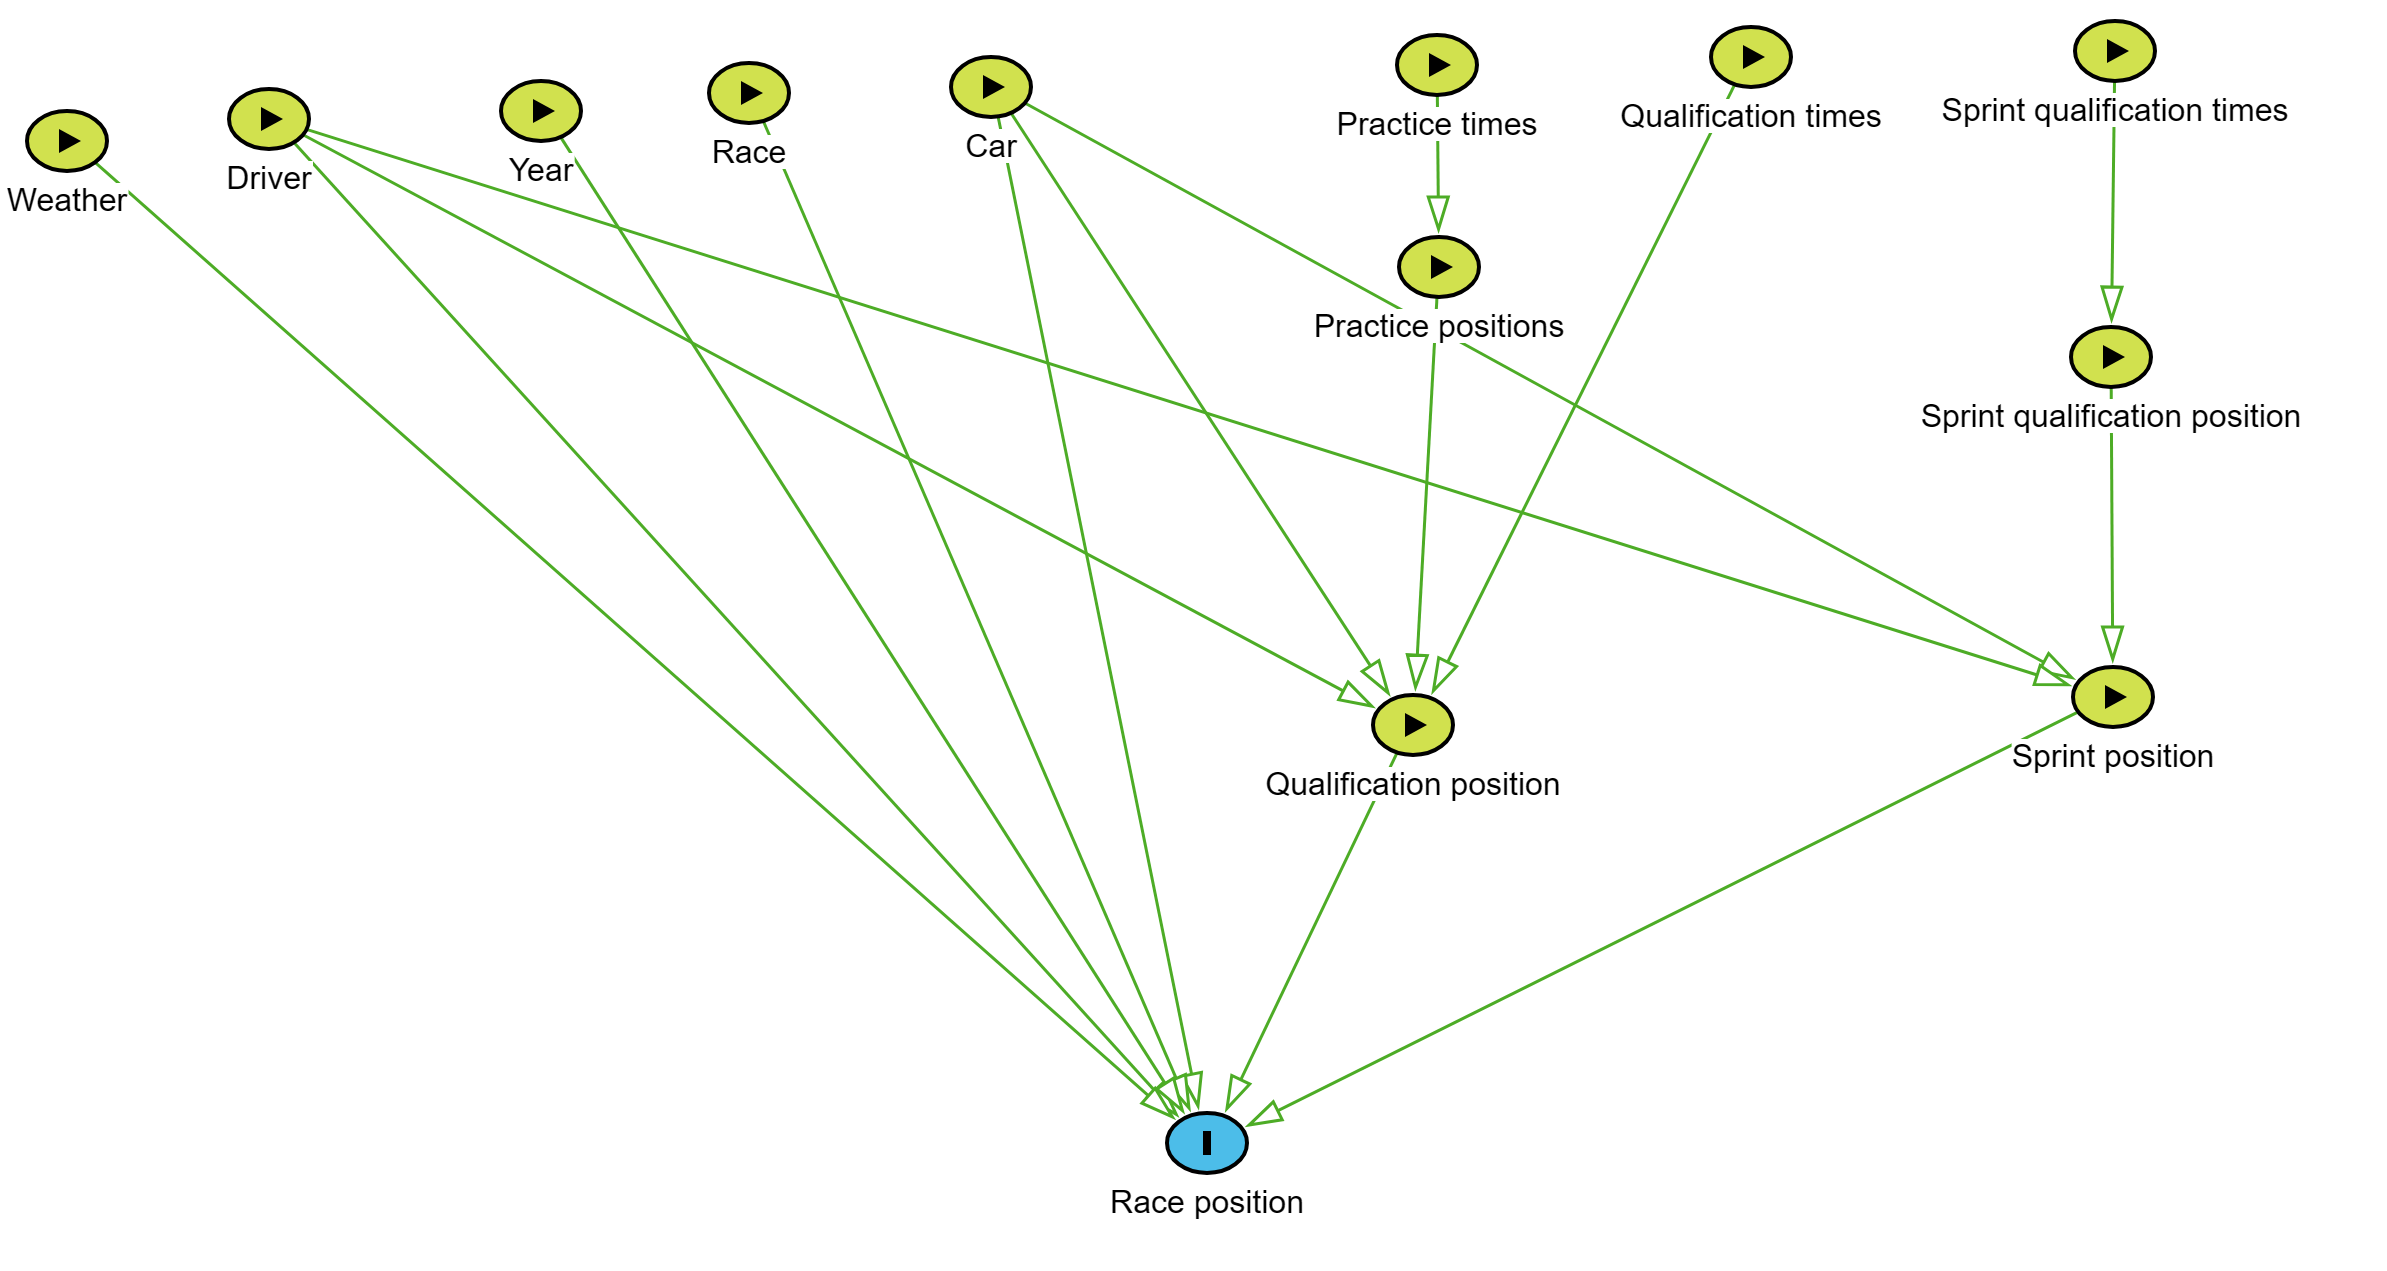

In [4]:
DAG = Image.open('DAG.png')
display(DAG)

In the models considered later in this paper, only certain variables deemed appropriate were selected. These variables were:
- Weather (track surface temperature and rain)
- Driver
- Year
- Race
- Car (manufacturer responsible for the design)
- Qualifying position

Variables that were excluded either had numerous data gaps (e.g., qualifications Q1, Q2, Q3) or were considered too insignificant to be included (e.g., positions in sprints).

### 1.5. Confoundings
1. **Pipes**:
<br>Weather -> Race position,
<br>Driver -> Race position,
<br>Driver -> Qualification position -> Race position,
<br>Driver -> Sprint position -> Race position,
<br>Year -> Race position,
<br>Race -> Race position,
<br>Car -> Race position,
<br>Car -> Qualification position -> Race position,
<br>Car -> Sprint position -> Race position,
<br>Practice times -> Practice positions -> Qualification position -> Race position,
<br>Qualification times -> Qualification position,
<br>Sprint qualification times -> Sprint qualification position -> Race position.

2. **Forks**:
<br>Driver cause changes in Race position, Qualification position and Sprint position,
<br>Car cause changes in Race position, Qualification position and Sprint position.

3. **Colliders**:
<br>Qualification position and Sprint position cause changes in Race position which is our outcome of analysis.

## 2. Data Preprocessing

### 2.1. Orginal Data

In [5]:
original_data = pd.read_csv('final_f1_data.csv')
original_data.head()

,Year,Race,No,Driver,Car,Pos (race),Laps (race),Time/Retired,Points,Pos (qualifying),...,SQ2,SQ3,Laps (Sprint Quali),AvgAirTemp,AvgHumidity,AvgPressure,TotalRainfall,AvgTrackTemp,AvgWindDirection,AvgWindSpeed
0,2022,Bahrain,16,Charles Leclerc LEC,Ferrari,1,57.0,1:37:33:584,26.0,1,...,NaN,NaN,NaN,23.62,29.49,1010.39,0,28.61,124.43,0.3
1,2022,Bahrain,10,Pierre Gasly GAS,AlphaTauri RBPT,NC,44.0,DNF,0.0,10,...,NaN,NaN,NaN,23.62,29.49,1010.39,0,28.61,124.43,0.3
2,2022,Bahrain,1,Max Verstappen VER,Red Bull Racing RBPT,19,54.0,DNF,0.0,2,...,NaN,NaN,NaN,23.62,29.49,1010.39,0,28.61,124.43,0.3
3,2022,Bahrain,11,Sergio Perez PER,Red Bull Racing RBPT,18,56.0,DNF,0.0,4,...,NaN,NaN,NaN,23.62,29.49,1010.39,0,28.61,124.43,0.3
4,2022,Bahrain,27,Nico Hulkenberg HUL,Aston Martin Aramco Mercedes,17,57.0,+63.829s,0.0,17,...,NaN,NaN,NaN,23.62,29.49,1010.39,0,28.61,124.43,0.3


In [6]:
original_data.describe()

,Year,No,Laps (race),Points,Pos (FP1),Laps (FP1),Pos (FP2),Laps (FP2),Pos (FP3),Laps (FP3),Laps (Sprint),Points (Sprint),Laps (Sprint Quali),AvgAirTemp,AvgHumidity,AvgPressure,TotalRainfall,AvgTrackTemp,AvgWindDirection,AvgWindSpeed
count,1048.000000,1048.000000,998.000000,998.000000,996.000000,996.000000,805.000000,805.000000,777.000000,777.000000,219.000000,219.000000,160.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000
mean,2022.669847,27.684160,54.092184,5.105210,10.464859,21.462851,10.350311,25.371429,10.463320,18.615187,19.150685,1.808219,12.050000,24.150658,52.957653,987.579284,10.746183,35.564170,182.211422,1.888263
std,0.674099,23.115599,16.418655,7.259757,5.753720,7.594340,5.710601,7.053627,5.750751,4.703577,5.292381,2.647437,4.821075,4.787239,17.095960,52.604867,38.036584,8.090855,61.259309,1.018147
min,2022.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.000000,12.900000,7.110000,779.520000,0.000000,17.420000,87.800000,0.300000
25%,2022.000000,11.000000,50.000000,0.000000,5.000000,19.000000,5.000000,22.000000,5.000000,16.000000,19.000000,0.000000,8.000000,20.460000,42.320000,991.200000,0.000000,30.140000,132.640000,1.260000
50%,2023.000000,22.000000,57.000000,1.000000,10.000000,23.000000,10.000000,26.000000,10.000000,19.000000,19.000000,0.000000,12.000000,24.860000,54.160000,1008.650000,0.000000,35.520000,173.240000,1.530000
75%,2023.000000,44.000000,65.000000,9.750000,15.000000,26.000000,15.000000,30.000000,15.000000,22.000000,24.000000,3.500000,15.000000,27.505000,63.080000,1012.930000,0.000000,41.690000,220.330000,2.270000
max,2024.000000,99.000000,78.000000,26.000000,20.000000,39.000000,20.000000,44.000000,20.000000,31.000000,24.000000,8.000000,24.000000,36.570000,87.450000,1020.600000,250.000000,54.460000,314.130000,5.490000


In [7]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048 entries, 0 to 1047
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   1048 non-null   int64  
 1   Race                   1048 non-null   object 
 2   No                     1048 non-null   int64  
 3   Driver                 1048 non-null   object 
 4   Car                    1048 non-null   object 
 5   Pos (race)             998 non-null    object 
 6   Laps (race)            998 non-null    float64
 7   Time/Retired           998 non-null    object 
 8   Points                 998 non-null    float64
 9   Pos (qualifying)       998 non-null    object 
 10  Q1                     998 non-null    object 
 11  Q2                     744 non-null    object 
 12  Q3                     494 non-null    object 
 13  Pos (FP1)              996 non-null    float64
 14  Time (FP1)             959 non-null    object 
 15  Gap 

### 2.2. Preprocessing of the orginal data

1. Selecting relevant and useful columns:
    - Year
    - Race
    - Driver
    - Car
    - Pos (race)
    - Points
    - Pos (qualifying)
    - TotalRainfall
    - AvgTrackTemp
    - Qualifying position
2. Data Cleaning: Replacing `NC` and `DQ` Values in the **Pos (race)** and **Pos (qualifying)** columns with the Last possible position
3. Choosing drivers who participated in each of the years considered.


In [38]:
# Step 1 
relevant_columns = ["Year", "Race", "Driver", "Car", "Pos (race)", "Points", "Pos (qualifying)", "TotalRainfall", "AvgTrackTemp", "Qualifying position"]
df_processed = original_data.filter(relevant_columns)

In [64]:
# Step 2
df_processed['Pos (race)'] = df_processed['Pos (race)'].astype(str)
df_processed['Pos (qualifying)'] = df_processed['Pos (qualifying)'].astype(str)

# Function to replace "NC" and "DQ" values with the next available place
def replace_nc_dq(group, column):
    # Sort by the given column to determine the next place
    positions = sorted([int(pos) for pos in group[column] if pos.isdigit()])
    next_place = max(positions) + 1 if positions else 1
    # Replace "NC" and "DQ" with the next place
    group[column] = group[column].replace(['NC', 'DQ'], next_place)
    return group
    
for col in ['Pos (race)', 'Pos (qualifying)']:
    df_processed = df_processed.groupby(['Year', 'Race'], group_keys=False).apply(replace_nc_dq, column=col)
    df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce').fillna(20).astype(int)

In [40]:
# Step 3
# Filter data for each year
drivers_2022 = set(df_processed[df_processed['Year'] == 2022]['Driver'])
drivers_2023 = set(df_processed[df_processed['Year'] == 2023]['Driver'])
drivers_2024 = set(df_processed[df_processed['Year'] == 2024]['Driver'])
# Find common drivers
common_drivers = drivers_2022 & drivers_2023 & drivers_2024
# Filter rows for these common drivers
df_processed = df_processed[df_processed['Driver'].isin(common_drivers)]

In [65]:
df_processed.head()

,Year,Race,Driver,Car,Pos (race),Points,Pos (qualifying),TotalRainfall,AvgTrackTemp,Driver_ratings,Consturtor_rating
0,2022,Bahrain,Charles Leclerc LEC,Ferrari,1,26.0,1,0,28.61,0.49,0.82
1,2022,Bahrain,Pierre Gasly GAS,AlphaTauri RBPT,20,0.0,10,0,28.61,0.39,0.50
2,2022,Bahrain,Max Verstappen VER,Red Bull Racing RBPT,19,0.0,2,0,28.61,0.55,0.90
3,2022,Bahrain,Sergio Perez PER,Red Bull Racing RBPT,18,0.0,4,0,28.61,0.43,0.90
4,2022,Bahrain,Nico Hulkenberg HUL,Aston Martin Aramco Mercedes,17,0.0,17,0,28.61,0.34,0.40


In [66]:
df_processed.to_csv('data_processing/processed_data.csv', index=False)

## 3. Models
The objective of all three models is to determine the positions y of drivers in a Formula 1 race.

$$ y \sim Binomial(N, \theta) $$


In Stan, the binomial distribution models the number of successes in a fixed number of trials, each with the same probability of success $\theta$.

For analyzing Formula 1 race positions from 2022 to 2024, the binomial distribution is ideal as it handles discrete outcomes like drivers' finishing positions. With 20 drivers per race, the number of trials N is 19, and the success probability $\theta$ is calculated separately for each model.\
This allows the estimation of $\theta$, the likelihood of a driver finishing in specific positions, considering multiple races as repeated trials.

Input values in Stan include N =19 and $\theta$, while the output is the posterior distribution of $\theta$ providing insights into driver performance across races. This straightforward model effectively captures race result variability due to factors in the hybrid era.

### 3.1. Model 1
$$
\theta = \alpha_{\text{driver}} + \alpha_{\text{car}}
$$

$$
\alpha_{\text{driver}} \sim \mathcal{N}(0, \sigma)
$$

$$
\alpha_{\text{car}} \sim \mathcal{N}(0, \sigma)
$$

Model 1 is a simple reference model [1] on which Models 2 and 3 are based.The $\theta$ was determined based on the average skills of the driver $\alpha_{\text{driver}}$ and the average benefits of the given car constructor $\alpha_{\text{car}}$. Both parameters are represented as normal distributions with a standard deviation of $\sigma$. The same $\sigma$ is used in both cases to ensure that the values of both distributions are similar and have an equal impact on the final evaluation of $\theta$.

**Descriptions of the parameters:**
- **Parameter $\alpha_{\text{driver}}$**\
The average skills of each driver are assessed by assigning them a value from a normal distribution with a standard deviation $\sigma$. Positive values suggest that the driver is below average, while negative values suggest that the driver is above average.

- **Parameter $\alpha_{\text{car}}$**\
The average benefits for each driver from selecting a car by a particular constructor are assessed by assigning each a value derived from a normal distribution with standard deviation $\sigma$. Positive values suggest that the constructor's performance is below average, whereas negative values suggest that the constructor's performance is above average.


### 3.2. Model 2
$$
\theta = \alpha_{\text{driver}} + \alpha_{\text{rain}} + \alpha_{\text{car}} + \alpha_{\text{temp}} 
$$

$$
\alpha_{\text{driver}} \sim \mathcal{N}(0, \sigma)
$$

$$
\alpha_{\text{rain}} \sim \mathcal{N}(0, \sigma_{\text{rain}}) \cdot \text{rainy}  
$$

$$
\alpha_{\text{car}} \sim \mathcal{N}(0, \sigma)
$$

$$
\alpha_{\text{temp}} \sim \mathcal{N}(0, \sigma_{\text{temp}})
$$


Weather conditions are a crucial factor in all types of sports, capable of changing the outcome in ways that can surprise spectators. The goal of Model 2 was to expand the basic model by incorporating weather-related information, such as track temperature and whether it rained during the race.

**Descriptions of the new parameters:**
- **Parameter $\alpha_{\text{rain}}$**\
Rain in Formula 1 races, though rare, is a factor that can significantly impact the final positions of drivers, revealing which ones handle it better and which ones handle it worse. The variable **rainy** is a boolean variable indicating whether it rained during the race. Depending on whether the value of **rainy** is 0 or 1, an additional normal distribution with a standard deviation of $\sigma_{\text{rain}}$ is included in the calculation of $\theta$, which should be interpreted as the driver's skill in handling the race when it rains.

- **Parameter $\alpha_{\text{temp}}$**\
Track temperature can also have a significant impact on race outcomes. The parameter $\alpha_{\text{temp}}$ is modeled as a normal distribution with a standard deviation of $\sigma_{\text{temp}}$. This parameter accounts for the varying performance of drivers and cars under different temperature conditions, reflecting how well they adapt to changes in track temperature during the race. By including $\alpha_{\text{temp}}$, the model can better evaluate a driver's skill and car performance in different thermal environments, providing a more comprehensive understanding of factors influencing race results.

### 3.3. Model 3
$$
\theta = \alpha_{\text{driver}} + \alpha_{\text{rain}} + \alpha_{\text{car}} + \alpha_{\text{quals}}
$$

$$
\alpha_{\text{driver}} \sim \mathcal{N}(0, \sigma)
$$

$$
\alpha_{\text{rain}} \sim \mathcal{N}(0, \sigma_{\text{rain}}) \cdot \text{rainy}  
$$

$$
\alpha_{\text{car}} \sim \mathcal{N}(0, \sigma)
$$

$$
\alpha_{\text{quals}} \sim \mathcal{N}(0, \sigma_{\text{quals}}) \cdot \text{passing_ratio}  
$$


In Formula 1 racing, before each race in which points are earned to determine the season standings, there are qualifying sessions consisting of three rounds: Q1, Q2, and Q3.\
Based on the results of these sessions, each driver receives their starting position. Overtaking during a Formula 1 race is difficult and relatively rare, except in unpredictable situations (such as rain, where it becomes more frequent).\
The position obtained in the qualifications is very important for the race because it is much easier for drivers in the leading positions to maintain their lead. The goal of this model is to account for these positions and their impact.

**Descriptions of the new parameters:**
- **Parameter $\alpha_{\text{quals}}$**\
The parameter $\alpha_{\text{quals}}$ is designed to incorporate the influence of the driver's starting position on the final race outcome. It is modeled as a normal distribution with a standard deviation of $\sigma_{\text{quals}}$, scaled by the variable **passing_ratio**, which represents the relative difficulty of overtaking during the race. A higher passing ratio indicates a greater likelihood of overtaking, reducing the impact of the qualifying position on the race result. Conversely, a lower passing ratio emphasizes the importance of a good starting position, as overtaking is more challenging. By including $\alpha_{\text{quals}}$ in the model, we can better understand how the qualifying performance and the race dynamics interact to influence the driver's final standing.

## 4. Priors 

### 4.1.  Explanation why particular priors for parameters were selected
- **Parameter $\alpha_{\text{driver}}$**\
The skill of each driver is modeled using a normal distribution $\mathcal{N}(0, \sigma)$. The choice of a normal distribution is based on the assumption that driver skills are symmetrically distributed around an average level, with some drivers performing better and others worse. The standard deviation $\sigma$ reflects the variability in driver skills.

- **Parameter $\alpha_{\text{car}}$**\
The performance benefit provided by each car constructor is also modeled using a normal distribution $\mathcal{N}(0, \sigma)$. This assumption is based on the belief that car performance, like driver skills, varies around an average level. The same $\sigma$ as for drivers ensures that the impact of cars and drivers on race outcomes is comparable.

- **Parameter $\alpha_{\text{rain}}$**\
The influence of rain is modeled with $\mathcal{N}(0, \sigma_{\text{rain}}) \cdot \text{rainy}$. The normal distribution reflects the variability in drivers' abilities to handle wet conditions, with the boolean variable rainy accounting for whether it rained. This captures the rare but impactful nature of rain on race results.

- **Parameter $\alpha_{\text{temp}}$**\
Track temperature effects are modeled with $\mathcal{N}(0, \sigma_{\text{temp}})$. The normal distribution is chosen to capture the varying impact of temperature on driver and car performance. The standard deviation $\sigma_{\text{temp}}$ represents the extent of this variability.

- **Parameter $\alpha_{\text{quals}}$**\
The effect of qualifying position is modeled with $\mathcal{N}(0, \sigma_{\text{quals}}) \cdot$ passing_ratio. The normal distribution represents the variability in the importance of starting positions, with the passing_ratio scaling this effect based on how easy it is to overtake in a race. This accounts for the significant role of qualifying performance in determining race outcomes.

### 4.2.  Predictive checks for parameters
Predictive checks involve generating simulated data from the model using the posterior distributions of the parameters and comparing it to the observed data. This helps to assess the model's ability to replicate real-world outcomes.

**Procedure**
1. Generate Simulated Data: Using the posterior distributions of the parameters $\alpha_{\text{driver}}$, $\alpha_{\text{car}}$, $\alpha_{\text{rain}}$, $\alpha_{\text{temp}}$, and $\alpha_{\text{quals}}$, generate simulated race results.
2. Compare to Observed Data: Compare the distribution of simulated race positions to the observed positions from the actual race data.
3. Diagnostic Metrics: Use metrics such as the posterior predictive p-value, which measures the proportion of simulated data that is more extreme than the observed data. Values near 0.5 indicate good model fit.

**Interpretation**
- If the simulated data closely matches the observed data, this suggests that the model's parameters are appropriately capturing the underlying processes influencing race outcomes.
- Discrepancies between simulated and observed data can indicate areas where the model might be improved, such as by including additional factors or refining the priors.

### 4.3.  Pior predictive checks for measurements
Prior predictive checks involve generating simulated data from the model using the prior distributions of the parameters, before observing any data. This helps to assess whether the chosen priors produce plausible outcomes.

**Procedure**
1. Generate Simulated Data: Using the prior distributions for $\alpha_{\text{driver}}$, $\alpha_{\text{car}}$, $\alpha_{\text{rain}}$, $\alpha_{\text{temp}}$, and $\alpha_{\text{quals}}$, generate simulated race results.
2. Compare to Plausible Outcomes: Compare the distribution of simulated race positions to what is considered plausible based on domain knowledge of Formula 1 racing.
3. Diagnostic Metrics: Use metrics such as the range and mean of the simulated race positions to ensure they fall within expected bounds (e.g., race positions between 1 and 20).

**Interpretation**
- If the simulated data from the priors results in implausible outcomes (e.g., all drivers finishing in the top positions or all in the bottom positions), this suggests that the priors may need to be adjusted.
- Plausible prior predictive checks ensure that the priors are reasonable and do not introduce bias or unrealistic assumptions into the model.

### 4.4.  Explanation how prior parameters were selected
The selection of prior parameters involves choosing the mean and standard deviation for the normal distributions used for each parameter. The following considerations were made:

- **Domain Knowledge**: Historical data and expert knowledge about the typical performance of drivers and cars, as well as the impact of rain, temperature, and qualifying positions, were used to inform the priors.
- **Centering and Variability**: Priors were centered around zero (e.g., $\mathcal{N}(0, \sigma)$) to reflect that, on average, drivers and cars are expected to be neither exceptionally good nor bad. The standard deviations ($\sigma$, $\sigma_{\text{rain}}$, $\sigma_{\text{temp}}$, $\sigma_{\text{quals}}$) were chosen to reflect realistic levels of variability observed in past race data.
- **Prior Predictive Checks**: Iterative adjustments were made to the prior parameters based on the outcomes of prior predictive checks, ensuring that the priors produced plausible simulated data before any real data was incorporated.

After thorough analysis and iterative prior predictive checks, the following values were selected for the standard deviations of the normal distributions:
- $\sigma = 1$\
This value reflects the typical variability in driver skills and car performance, ensuring a balanced impact of both factors on the race outcomes.


- $\sigma_{\text{rain}} = 2$\
A higher value was chosen to capture the significant and variable impact of rain on race outcomes, reflecting the increased difficulty and unpredictability of wet conditions.


- $\sigma_{\text{temp}} = 0.5$\
This value represents the variability in performance due to different track temperatures, accounting for how well drivers and cars adapt to varying thermal environments.


- $\sigma_{\text{quals}} = 1$\
This value captures the importance of qualifying positions on race outcomes, scaled by the passing ratio to account for the difficulty of overtaking during races.


By carefully selecting and validating the prior parameters through these steps, the model is grounded in realistic assumptions and is better equipped to make accurate predictions about race outcomes in the hybrid era of Formula 1 racing.

### 4.5. Prior for model 1

In [28]:
df = pd.read_csv('data_processing/processed_data.csv')
unique_drivers = df['Driver'].nunique()
data = {
    'D': unique_drivers,
}

model = CmdStanModel(stan_file='stan/model1_prior.stan')
prior_model_1 = model.sample(data=data, iter_sampling=1000, chains=1, fixed_param=True)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


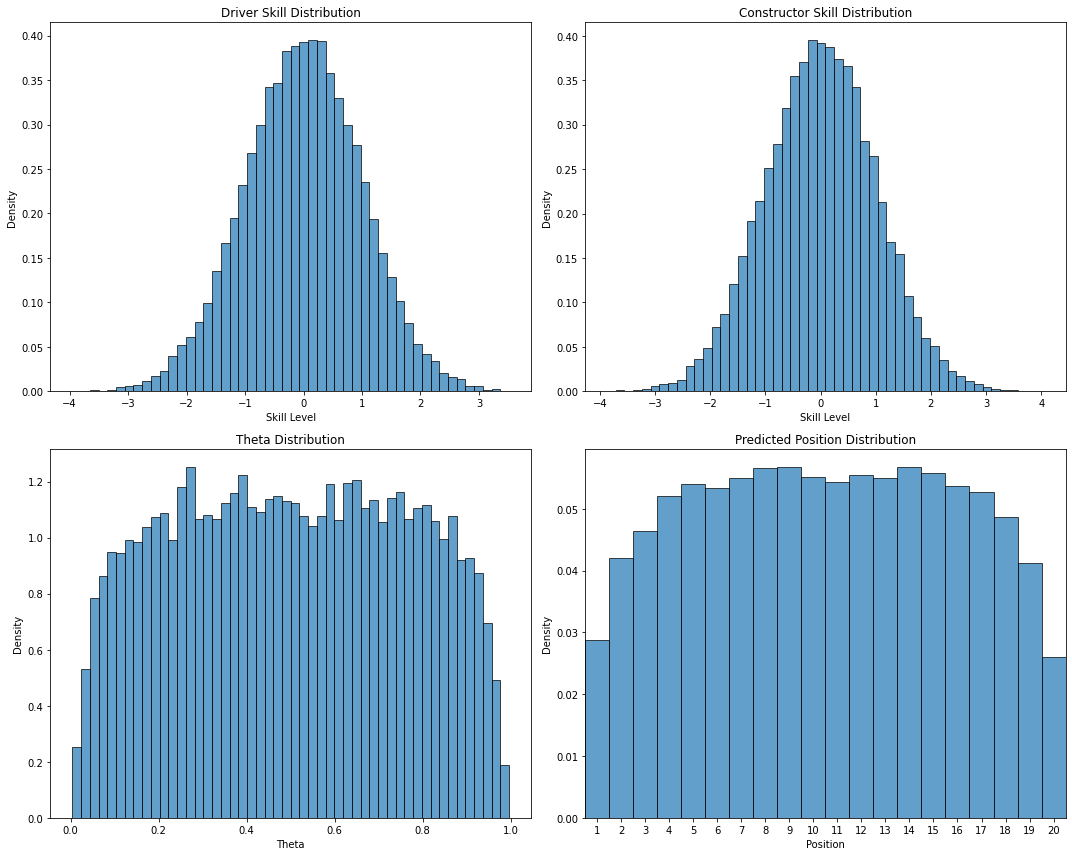

In [29]:
driver_skill_flat = prior_model_1.stan_variable('driver_skill').flatten()
constructor_skill_flat = prior_model_1.stan_variable('constructor_skill').flatten()
position_flat = prior_model_1.stan_variable('position').flatten() + 1
theta_flat = prior_model_1.stan_variable('theta').flatten()

fig, axs = plt.subplots(2, 2, figsize=(15, 12))

axs[0, 0].hist(driver_skill_flat, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[0, 0].set_title('Driver Skill Distribution')
axs[0, 0].set_xlabel('Skill Level')
axs[0, 0].set_ylabel('Density')

axs[0, 1].hist(constructor_skill_flat, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[0, 1].set_title('Constructor Skill Distribution')
axs[0, 1].set_xlabel('Skill Level')
axs[0, 1].set_ylabel('Density')

axs[1, 0].hist(theta_flat, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[1, 0].set_title('Theta Distribution')
axs[1, 0].set_xlabel('Theta')
axs[1, 0].set_ylabel('Density')

axs[1, 1].hist(position_flat, bins=np.arange(1, 22) - 0.5, edgecolor='black', alpha=0.7, density=True)
axs[1, 1].set_title('Predicted Position Distribution')
axs[1, 1].set_xlabel('Position')
axs[1, 1].set_ylabel('Density')
axs[1, 1].set_xticks(range(1, 21))
axs[1, 1].set_xlim([0.5, 20.5])

plt.tight_layout()
plt.show()

- The symmetry around zero in the top histograms indicates that there is no inherent bias in the priors towards higher or lower values for driver skill or car performance.
- The standard deviation of 1 for both $\sigma_{\text{driver}}$ and $\sigma_{\text{car}}$ suggests moderate variability, meaning that while most values are close to zero, there is a reasonable chance of observing more extreme values.
- The bottom histograms highlight the range of $\theta$ values that can be expected before observing any data, demonstrating the combined variability introduced by both driver and car factors.

### 4.6. Prior for model 2

In [22]:
df = pd.read_csv('data_processing/processed_data.csv')
unique_drivers = df['Driver'].nunique()
rainy = [random.choice([0, 1]) for _ in range(unique_drivers)]
data = {
    'D': unique_drivers,
    'rainy': rainy
}

model = CmdStanModel(stan_file='stan/model2_prior.stan')
prior_model_2 = model.sample(data=data, iter_sampling=1000, chains=1, fixed_param=True)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


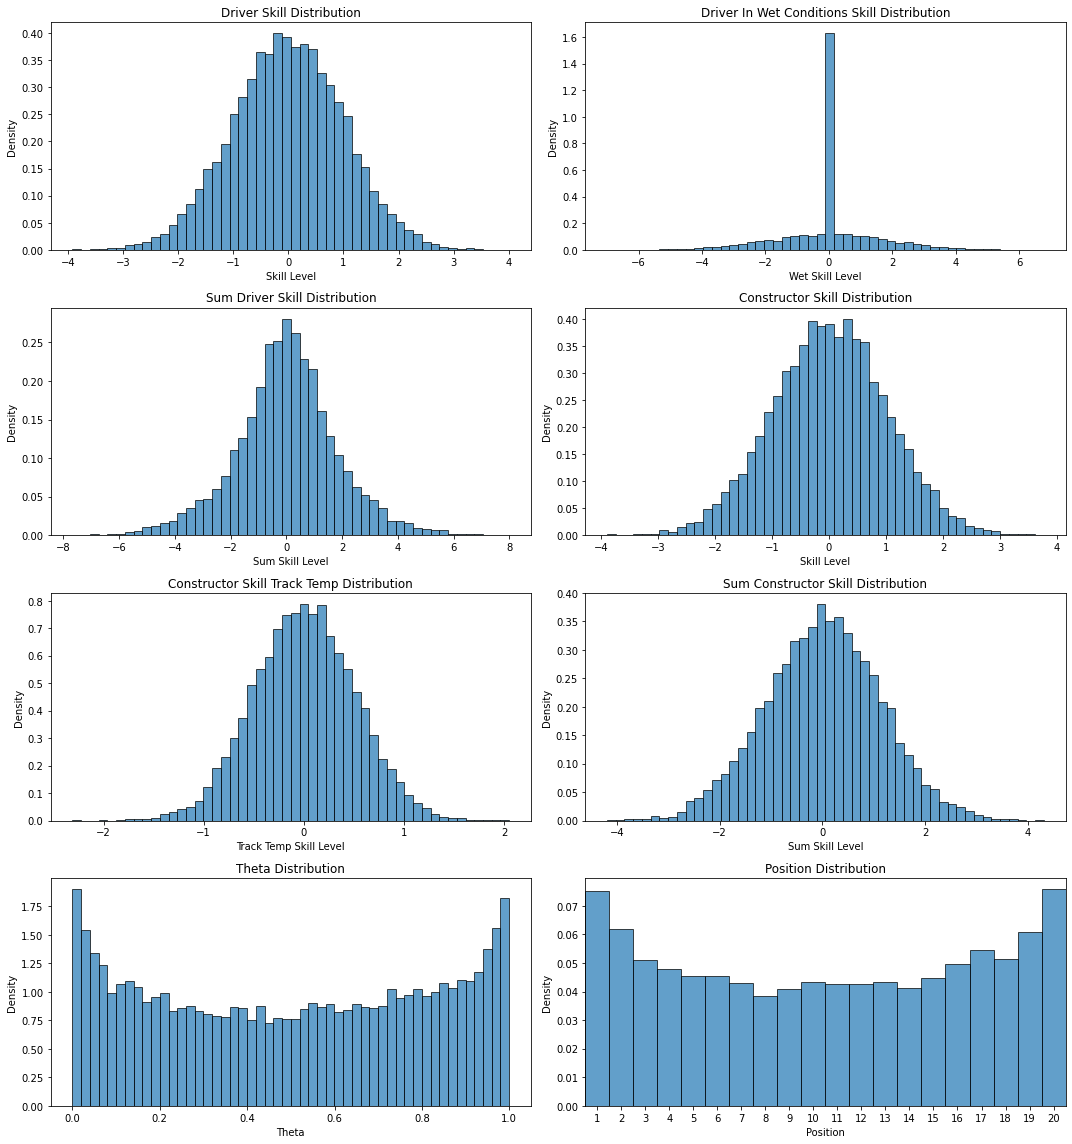

In [23]:
driver_skill_flat = prior_model_2.stan_variable('driver_skill').flatten()
driver_skill_wet_flat = prior_model_2.stan_variable('driver_skill_wet').flatten()
driver_skill_sum_flat = prior_model_2.stan_variable('driver_skill_sum').flatten()
constructor_skill_flat = prior_model_2.stan_variable('constructor_skill').flatten()
constructor_skill_flat_track_temp = prior_model_2.stan_variable('constructor_skill_track_temp').flatten()
constructor_skill_flat_sum = prior_model_2.stan_variable('constructor_skill_sum').flatten()
position_flat = prior_model_2.stan_variable('position').flatten() + 1
theta_flat = prior_model_2.stan_variable('theta').flatten()


fig, axs = plt.subplots(4, 2, figsize=(15, 16))

axs[0, 0].hist(driver_skill_flat, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[0, 0].set_title('Driver Skill Distribution')
axs[0, 0].set_xlabel('Skill Level')
axs[0, 0].set_ylabel('Density')

axs[0, 1].hist(driver_skill_wet_flat, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[0, 1].set_title('Driver In Wet Conditions Skill Distribution')
axs[0, 1].set_xlabel('Wet Skill Level')
axs[0, 1].set_ylabel('Density')

axs[1, 0].hist(driver_skill_sum_flat, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[1, 0].set_title('Sum Driver Skill Distribution')
axs[1, 0].set_xlabel('Sum Skill Level')
axs[1, 0].set_ylabel('Density')

axs[1, 1].hist(constructor_skill_flat, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[1, 1].set_title('Constructor Skill Distribution')
axs[1, 1].set_xlabel('Skill Level')
axs[1, 1].set_ylabel('Density')

axs[2, 0].hist(constructor_skill_flat_track_temp, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[2, 0].set_title('Constructor Skill Track Temp Distribution')
axs[2, 0].set_xlabel('Track Temp Skill Level')
axs[2, 0].set_ylabel('Density')

axs[2, 1].hist(constructor_skill_flat_sum, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[2, 1].set_title('Sum Constructor Skill Distribution')
axs[2, 1].set_xlabel('Sum Skill Level')
axs[2, 1].set_ylabel('Density')

axs[3, 0].hist(theta_flat, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[3, 0].set_title('Theta Distribution')
axs[3, 0].set_xlabel('Theta')
axs[3, 0].set_ylabel('Density')

axs[3, 1].hist(position_flat, bins=np.arange(1, 22) - 0.5, edgecolor='black', alpha=0.7, density=True)
axs[3, 1].set_title('Position Distribution')
axs[3, 1].set_xlabel('Position')
axs[3, 1].set_ylabel('Density')
axs[3, 1].set_xticks(range(1, 21))
axs[3, 1].set_xlim([0.5, 20.5])

plt.tight_layout()
plt.show()

The introduction of weather parameters, specifically related to weather and track temperature, in the second model caused an interesting shift in the distribution of positions. In the first model, the highest probabilities were centered in the middle, whereas in the second model, the highest probabilities were for the first and last positions. From the remaining charts, it can be observed that the main reason for this is precipitation, which makes both overtaking and failing to finish the race (for example, due to an accident caused by slipping) more likely.

### 4.7. Prior for model 3

In [24]:
df = pd.read_csv('data_processing/processed_data.csv')
unique_drivers = df['Driver'].nunique()
rainy = [random.choice([0, 1]) for _ in range(unique_drivers)]
qualifying_position = [random.randint(1, 20) for _ in range(unique_drivers)]
data = {
    'D': unique_drivers,
    'rainy': rainy,
    'qualifying_position': qualifying_position
}

model = CmdStanModel(stan_file='stan/model3_prior.stan')
prior_model_3 = model.sample(data=data, iter_sampling=1000, chains=1, fixed_param=True)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


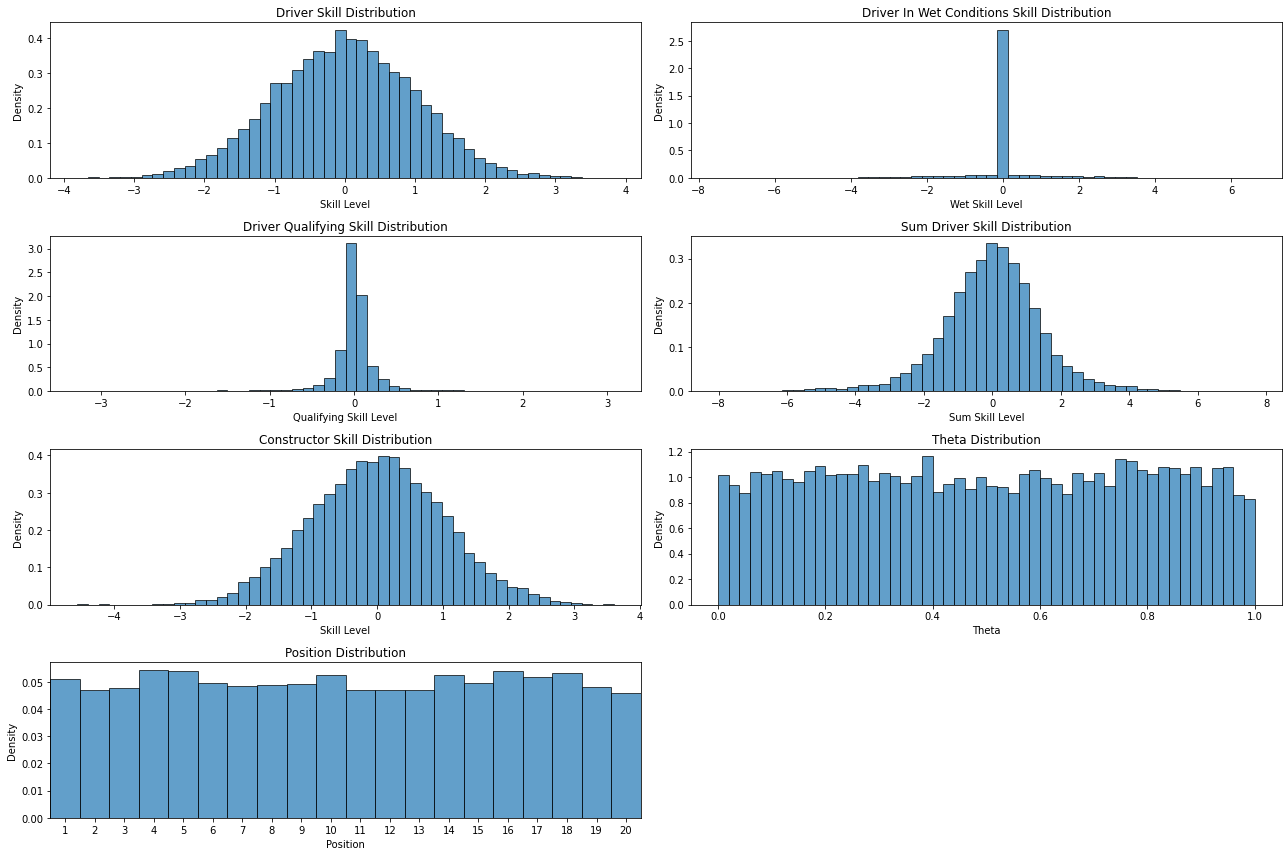

In [25]:
driver_skill_flat = prior_model_3.stan_variable('driver_skill').flatten()
driver_skill_wet_flat = prior_model_3.stan_variable('driver_skill_wet').flatten()
driver_skill_qualifying = prior_model_3.stan_variable('driver_skill_qualifying').flatten()
driver_skill_sum_flat = prior_model_3.stan_variable('driver_skill_sum').flatten()
constructor_skill_flat = prior_model_3.stan_variable('constructor_skill').flatten()
position_flat = prior_model_3.stan_variable('position').flatten() + 1
theta_flat = prior_model_3.stan_variable('theta').flatten()

fig, axs = plt.subplots(4, 2, figsize=(18, 12))

axs[0, 0].hist(driver_skill_flat, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[0, 0].set_title('Driver Skill Distribution')
axs[0, 0].set_xlabel('Skill Level')
axs[0, 0].set_ylabel('Density')

axs[0, 1].hist(driver_skill_wet_flat, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[0, 1].set_title('Driver In Wet Conditions Skill Distribution')
axs[0, 1].set_xlabel('Wet Skill Level')
axs[0, 1].set_ylabel('Density')

axs[1, 0].hist(driver_skill_qualifying, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[1, 0].set_title('Driver Qualifying Skill Distribution')
axs[1, 0].set_xlabel('Qualifying Skill Level')
axs[1, 0].set_ylabel('Density')

axs[1, 1].hist(driver_skill_sum_flat, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[1, 1].set_title('Sum Driver Skill Distribution')
axs[1, 1].set_xlabel('Sum Skill Level')
axs[1, 1].set_ylabel('Density')

axs[2, 0].hist(constructor_skill_flat, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[2, 0].set_title('Constructor Skill Distribution')
axs[2, 0].set_xlabel('Skill Level')
axs[2, 0].set_ylabel('Density')

axs[2, 1].hist(theta_flat, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[2, 1].set_title('Theta Distribution')
axs[2, 1].set_xlabel('Theta')
axs[2, 1].set_ylabel('Density')

axs[3, 0].hist(position_flat, bins=np.arange(1, 22) - 0.5, edgecolor='black', alpha=0.7, density=True)
axs[3, 0].set_title('Position Distribution')
axs[3, 0].set_xlabel('Position')
axs[3, 0].set_ylabel('Density')
axs[3, 0].set_xticks(range(1, 21))
axs[3, 0].set_xlim([0.5, 20.5])

fig.delaxes(axs[3, 1])
plt.tight_layout()
plt.show()

- The histograms for the combined distributions indicate a broader range of possible values for $\theta$, reflecting the realistic complexity and variability in race outcomes when all influential factors are considered.
- The parameter defining the position positively influenced the determination of the position. The values of $\theta$ and the predicted positions aligned, considering not only whether it was raining but also the starting positions of each driver in the race.

## 5. Posterior analysis (model 1)

### 5.1.  Issues with the sampling
There were no issues. All samplings were conducted without any obstacles.

### 5.2. Analysis of samples from the posterior predictive distribution

In [72]:
df = pd.read_csv('data_processing/processed_data.csv')
df = df.dropna(subset=['Driver', 'Car'])
unique_drivers = df['Driver'].nunique()
unique_constructors = df['Car'].nunique()
drivers_indices = pd.factorize(df['Driver'])[0] + 1
constructors_indices = pd.factorize(df['Car'])[0] + 1
df['Pos (race)'] = df['Pos (race)'] - 1
positions = df['Pos (race)'].values
data = {
    'N': len(df),
    'D': unique_drivers,
    'C': unique_constructors,
    'drivers': drivers_indices,
    'constructors': constructors_indices,
    'position': positions
}
model = CmdStanModel(stan_file='stan/model1_posterior.stan')
posterior_model_1 = model.sample(data=data, iter_warmup=1, iter_sampling=1000, chains=1, seed=20052024)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:02 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [73]:
def plot_comparision_between_simulated_and_observed_for_drivers(model, df):
    df = pd.read_csv('data_processing/processed_data.csv')
    n_rows, n_cols = 6, 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 5*n_rows))
    n_bins = np.arange(22) - 0.5

    drivers_names = df['Driver'].unique().tolist()

    for driver_index, driver_name in enumerate(drivers_names):
        specified_driver = df['Driver'].eq(driver_name)
        results = df[specified_driver]

        row_idx = driver_index // n_cols
        col_idx = driver_index % n_cols

        axes[row_idx, col_idx].hist((results['Pos (race)']).tolist(), bins=n_bins, rwidth=1, color='red', edgecolor='red', density=True, label='Observed', alpha=0.5)

        results_idx = results.index
        simulated_positions = model.T[results_idx].flatten() + 1
        axes[row_idx, col_idx].hist(simulated_positions, bins=n_bins, rwidth=1, color='lightblue', edgecolor='lightblue', density=True, label='Simulated', alpha=0.5)
        axes[row_idx, col_idx].set_xticks(range(22))
        axes[row_idx, col_idx].set_xlim([0, 21])
        axes[row_idx, col_idx].set_yticks([])
        axes[row_idx, col_idx].set_title(driver_name.split()[-1] + ' Finishing Positions (2022-2024)')
        axes[row_idx, col_idx].legend()
        axes[row_idx, col_idx].set_xlabel('Position')

    fig.tight_layout()
    plt.show()

IndexError: index 6 is out of bounds for axis 0 with size 6

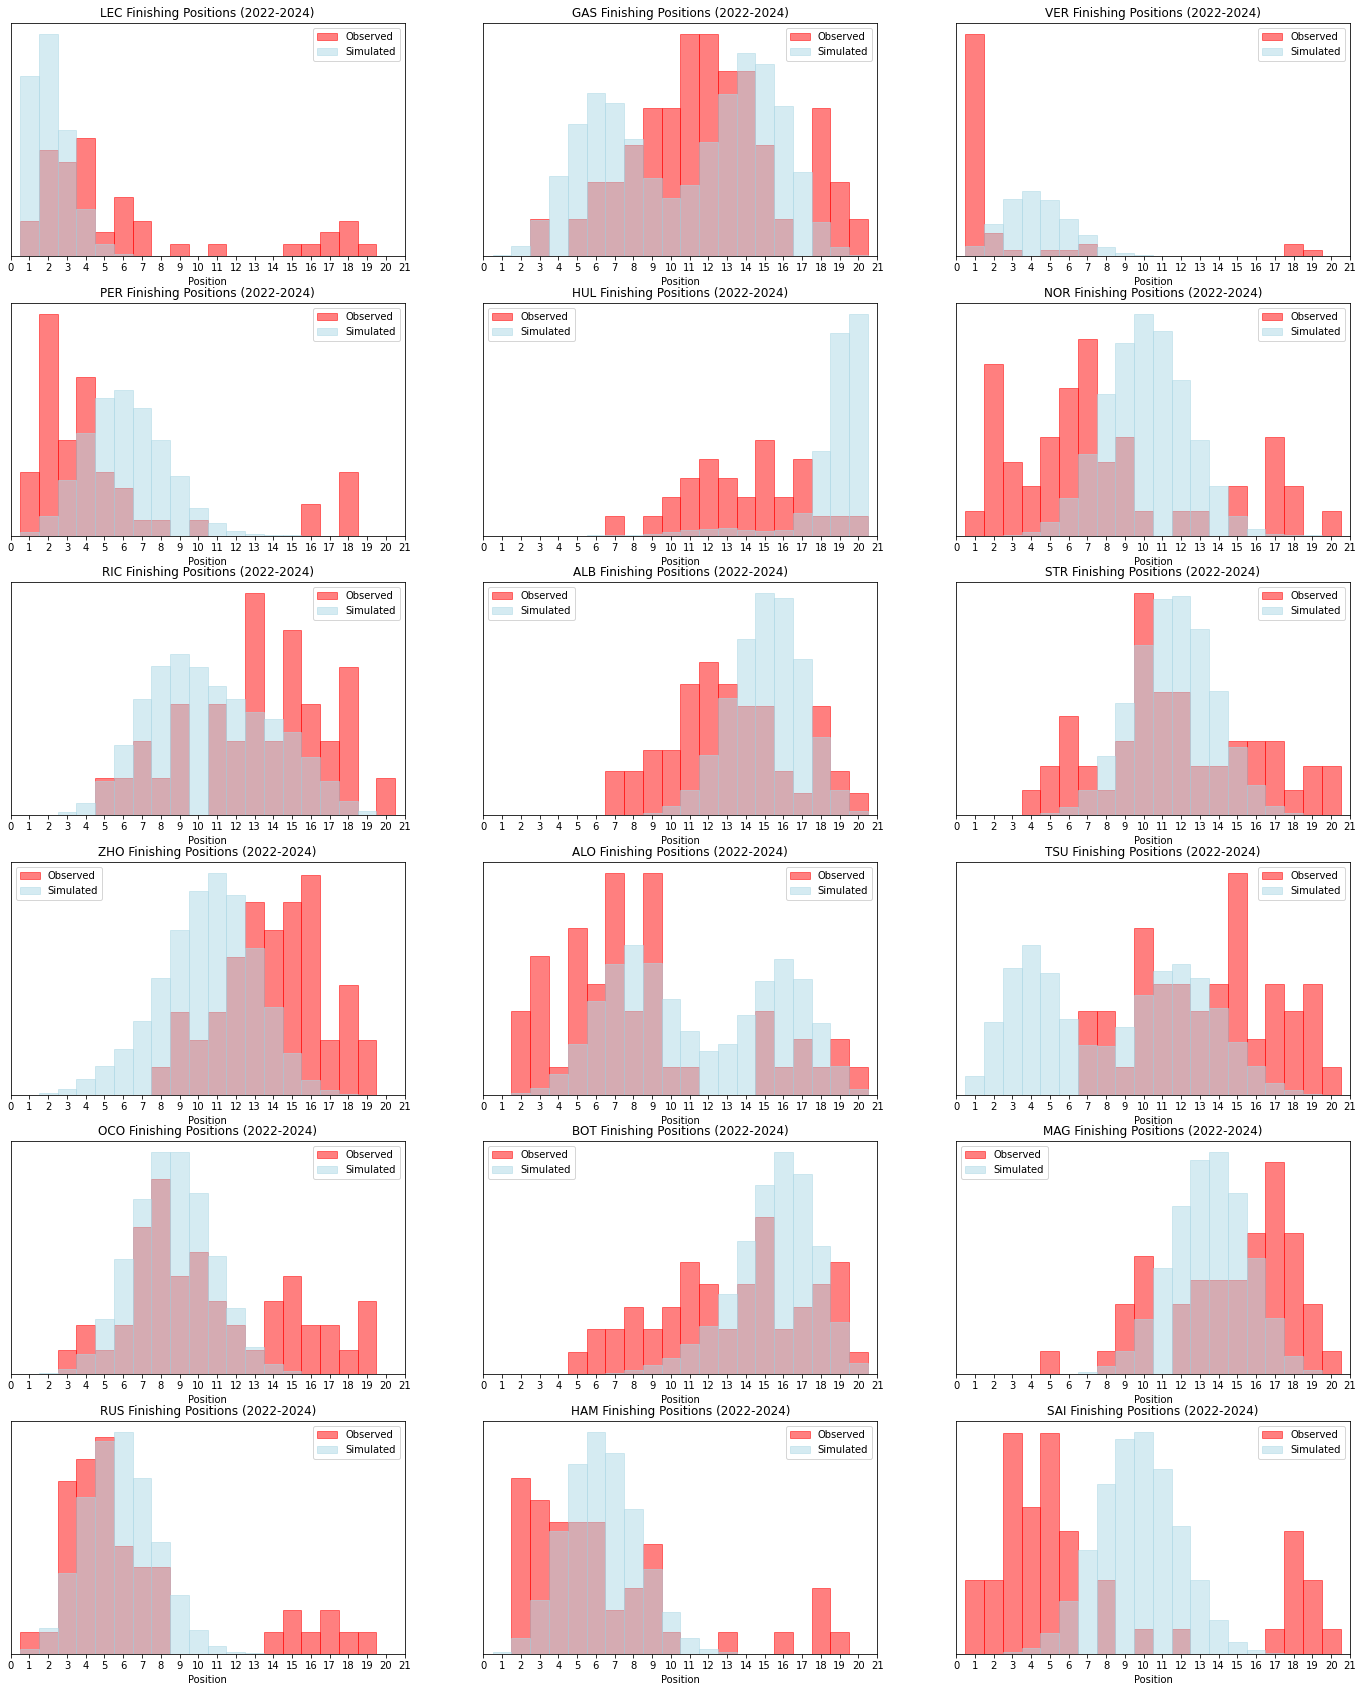

In [98]:
positions_predicted_model1 = posterior_model_1.stan_variable('position_predicted')
plot_comparision_between_simulated_and_observed_for_drivers(positions_predicted_model1, df)

The posterior predictive distributions from Model 1 generally align with the observed race results, indicating that the model captures the central tendencies and variability of driver performance adequately. However, there are instances where the simulated distributions exhibit biases, either overestimating or underestimating the drivers' performance. The model captures the overall spread of the data, but occasionally fails to account for extreme values and distribution shapes in certain cases. Overall, Model 1 provides a reasonable fit, but there is room for improvement in capturing more nuanced aspects of the race outcomes.

### 5.3. Analysis of parameter marginal disrtibutions

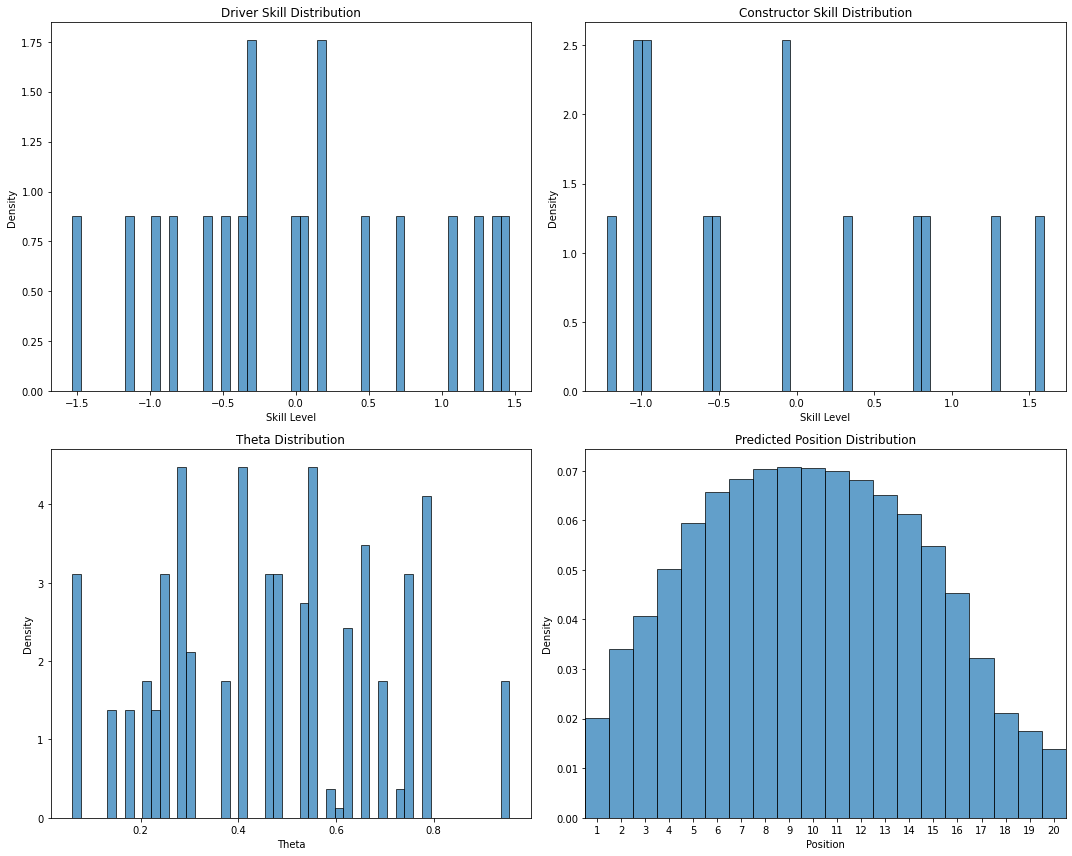

In [74]:
driver_skill_flat = posterior_model_1.stan_variable('driver_skill').flatten()
constructor_skill_flat = posterior_model_1.stan_variable('constructor_skill').flatten()
position_flat = posterior_model_1.stan_variable('position_predicted').flatten() + 1
theta_flat = posterior_model_1.stan_variable('theta').flatten()

fig, axs = plt.subplots(2, 2, figsize=(15, 12))

axs[0, 0].hist(driver_skill_flat, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[0, 0].set_title('Driver Skill Distribution')
axs[0, 0].set_xlabel('Skill Level')
axs[0, 0].set_ylabel('Density')

axs[0, 1].hist(constructor_skill_flat, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[0, 1].set_title('Constructor Skill Distribution')
axs[0, 1].set_xlabel('Skill Level')
axs[0, 1].set_ylabel('Density')

axs[1, 0].hist(theta_flat, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[1, 0].set_title('Theta Distribution')
axs[1, 0].set_xlabel('Theta')
axs[1, 0].set_ylabel('Density')

axs[1, 1].hist(position_flat, bins=np.arange(1, 22) - 0.5, edgecolor='black', alpha=0.7, density=True)
axs[1, 1].set_title('Predicted Position Distribution')
axs[1, 1].set_xlabel('Position')
axs[1, 1].set_ylabel('Density')
axs[1, 1].set_xticks(range(1, 21))
axs[1, 1].set_xlim([0.5, 20.5])

plt.tight_layout()
plt.show()

These distributions reflect the estimated variability and uncertainty in the model parameters, such as driver skill and car performance.\
The peaks and spreads in the histograms indicate how the parameters are distributed across different races, with some parameters showing more concentrated distributions and others exhibiting broader variability.\
Overall, the distributions provide insight into the range and tendencies of the model parameters, highlighting where the model finds consistency and where there is more uncertainty or variability in driver and car effects.

### 5.4. Results for individual drivers and constructors

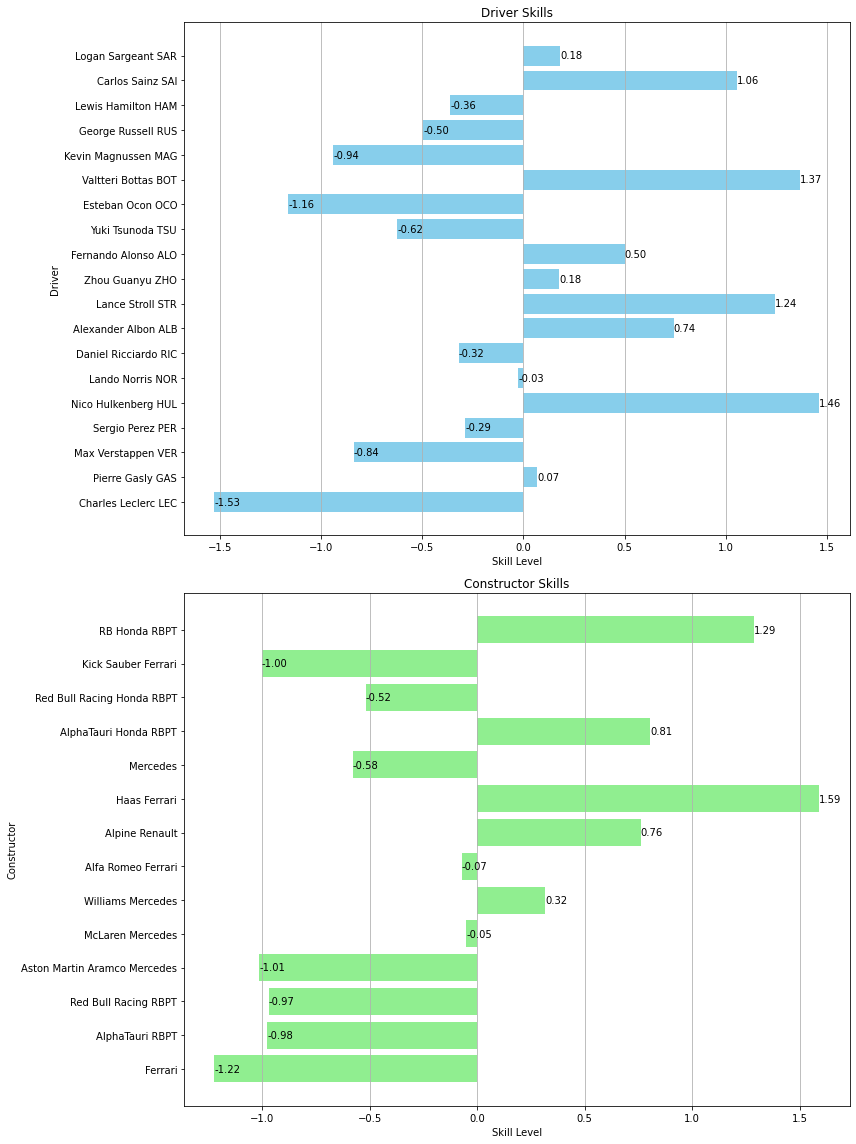

In [75]:
driver_skill_model1 = posterior_model_1.stan_variable('driver_skill')
constructor_skill_model1 = posterior_model_1.stan_variable('constructor_skill')

unique_driver_names = df['Driver'].unique()
unique_constructor_names = df['Car'].unique()

mean_driver_skill_model1 = np.mean(driver_skill_model1, axis=0)
mean_constructor_skill_model1 = np.mean(constructor_skill_model1, axis=0)

fig, axs = plt.subplots(2, 1, figsize=(12, 16))

bars = axs[0].barh(unique_driver_names, mean_driver_skill_model1, color='skyblue')
axs[0].set_xlabel('Skill Level')
axs[0].set_ylabel('Driver')
axs[0].set_title('Driver Skills')
axs[0].grid(axis='x')
for bar in bars:
    axs[0].text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', 
                va='center', ha='left', color='black')


bars = axs[1].barh(unique_constructor_names, mean_constructor_skill_model1, color='lightgreen')
axs[1].set_xlabel('Skill Level')
axs[1].set_ylabel('Constructor')
axs[1].set_title('Constructor Skills')
axs[1].grid(axis='x')
for bar in bars:
    axs[1].text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', 
                va='center', ha='left', color='black')

plt.tight_layout()
plt.show()

## 6. Posterior analysis (model 2)

### 6.1.  Issues with the sampling
There were no issues. All samplings were conducted without any obstacles.

### 6.2. Analysis of samples from the posterior predictive distribution

In [79]:
df = pd.read_csv('data_processing/processed_data.csv')
unique_drivers = df['Driver'].nunique()
unique_constructors = df['Car'].nunique()
drivers_indices = pd.factorize(df['Driver'])[0] + 1
constructors_indices = pd.factorize(df['Car'])[0] + 1
df['Pos (race)'] = pd.to_numeric(df['Pos (race)'], errors='coerce')
df['Pos (race)'] = df['Pos (race)'].astype(int) - 1
positions = df['Pos (race)'].values
rainy = df['TotalRainfall'].astype(bool).astype(int).values
avg_track_temp = df['AvgTrackTemp'].values
df['Pos (qualifying)'] = df['Pos (qualifying)'].astype(int) - 1
qualifying_positions = df['Pos (qualifying)'].values
data = {
    'N': len(df),
    'D': unique_drivers,
    'C': unique_constructors,
    'drivers': drivers_indices,
    'constructors': constructors_indices,
    'position': positions,
    'qualifying_position': qualifying_positions,
    'rainy': rainy,
    'avg_track_temp': avg_track_temp
}
model = CmdStanModel(stan_file='stan/model2_posterior.stan')
posterior_model_2 = model.sample(data=data, iter_warmup=1, iter_sampling=1000, chains=1, seed=20052024)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:03 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


IndexError: index 6 is out of bounds for axis 0 with size 6

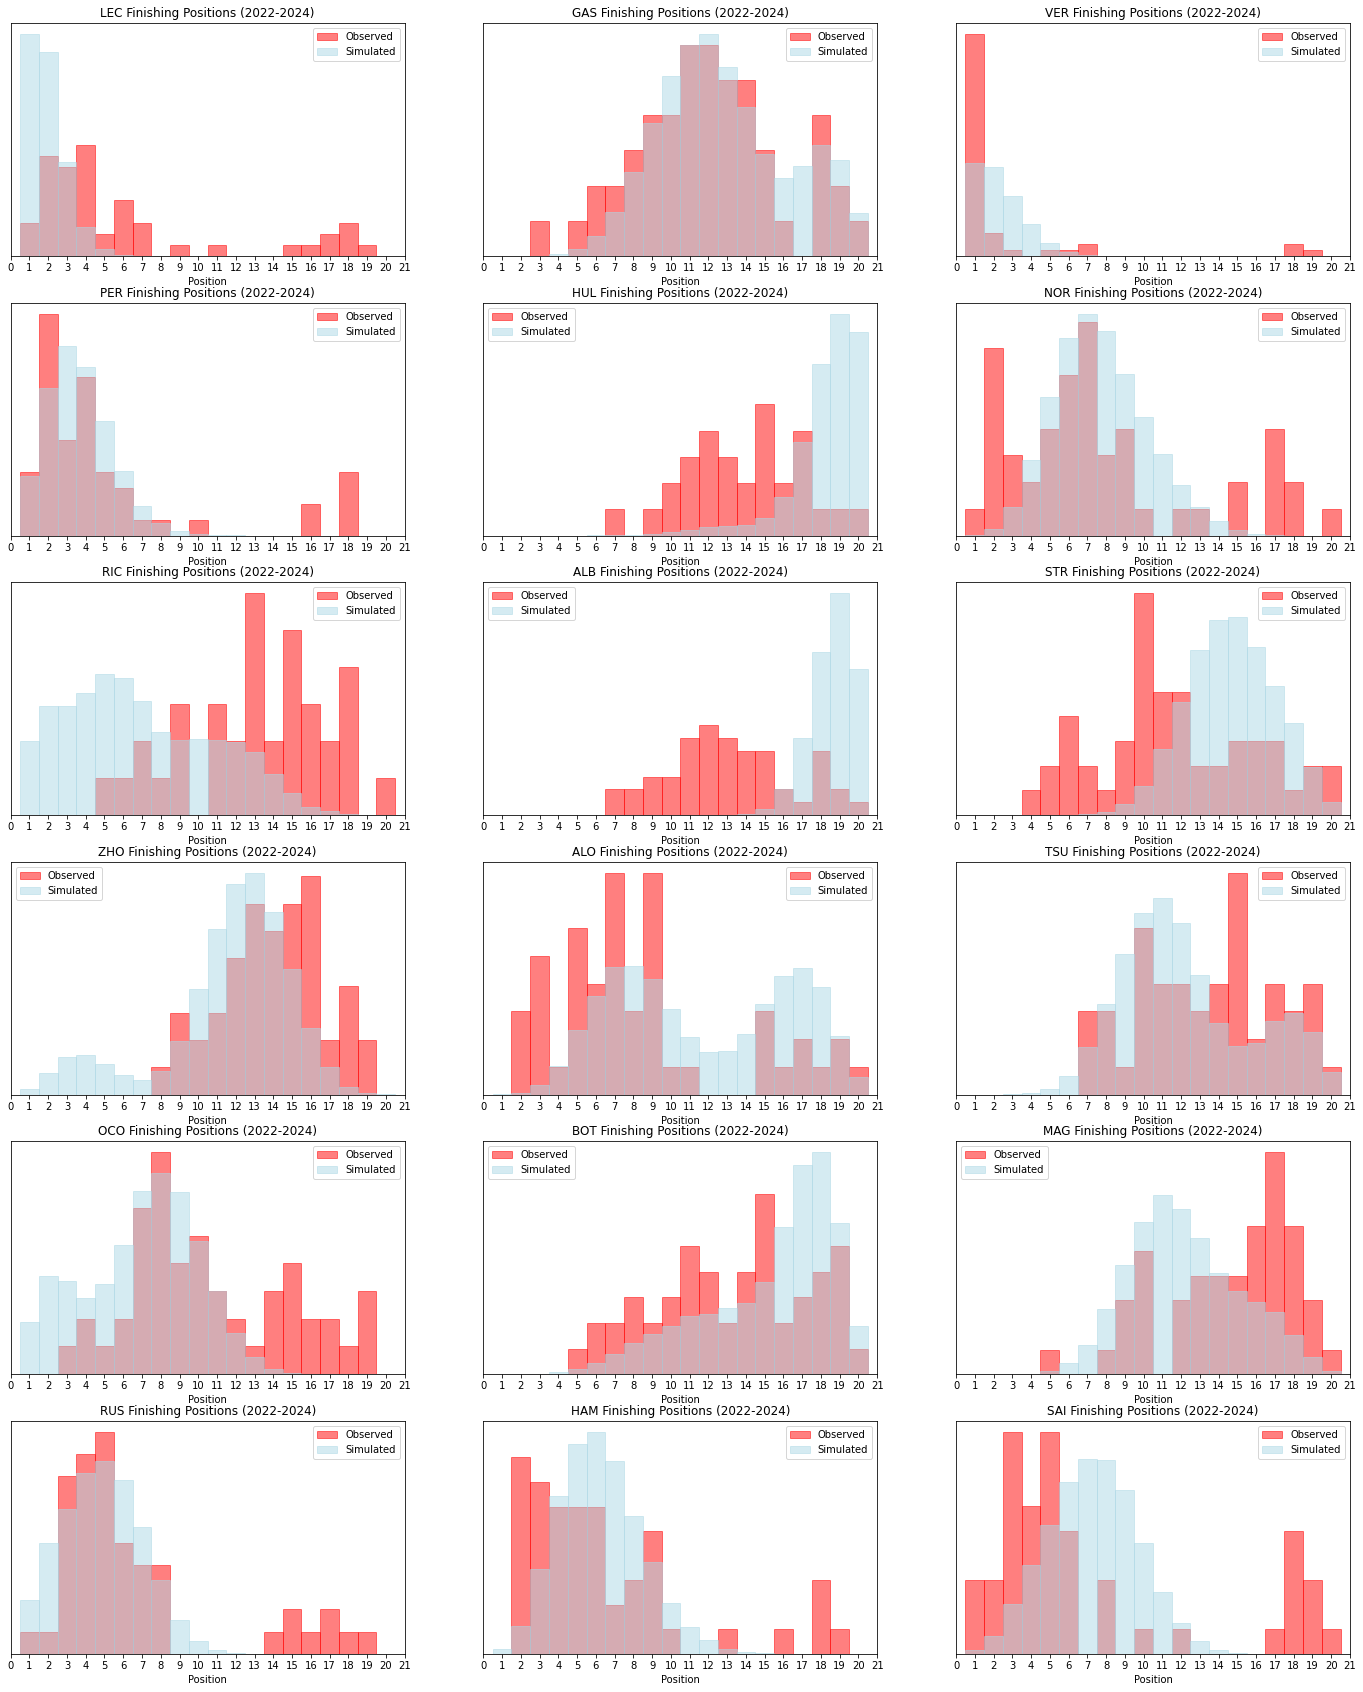

In [86]:
positions_predicted_model2 = posterior_model_2.stan_variable('position_predicted')
plot_comparision_between_simulated_and_observed_for_drivers(positions_predicted_model2, df)

The simulated distributions (in blue)  capture the trends and variability seen in the observed data (in red), though there are noticeable mismatches in specific bins. Some races exhibit good agreement between observed and simulated distributions, while others show discrepancies, indicating potential areas where the model might underperform or require refinement. Overall, the model reasonably approximates driver finishing positions, but further tuning or additional factors might be needed to enhance its predictive accuracy

### 6.3. Analysis of parameter marginal disrtibutions

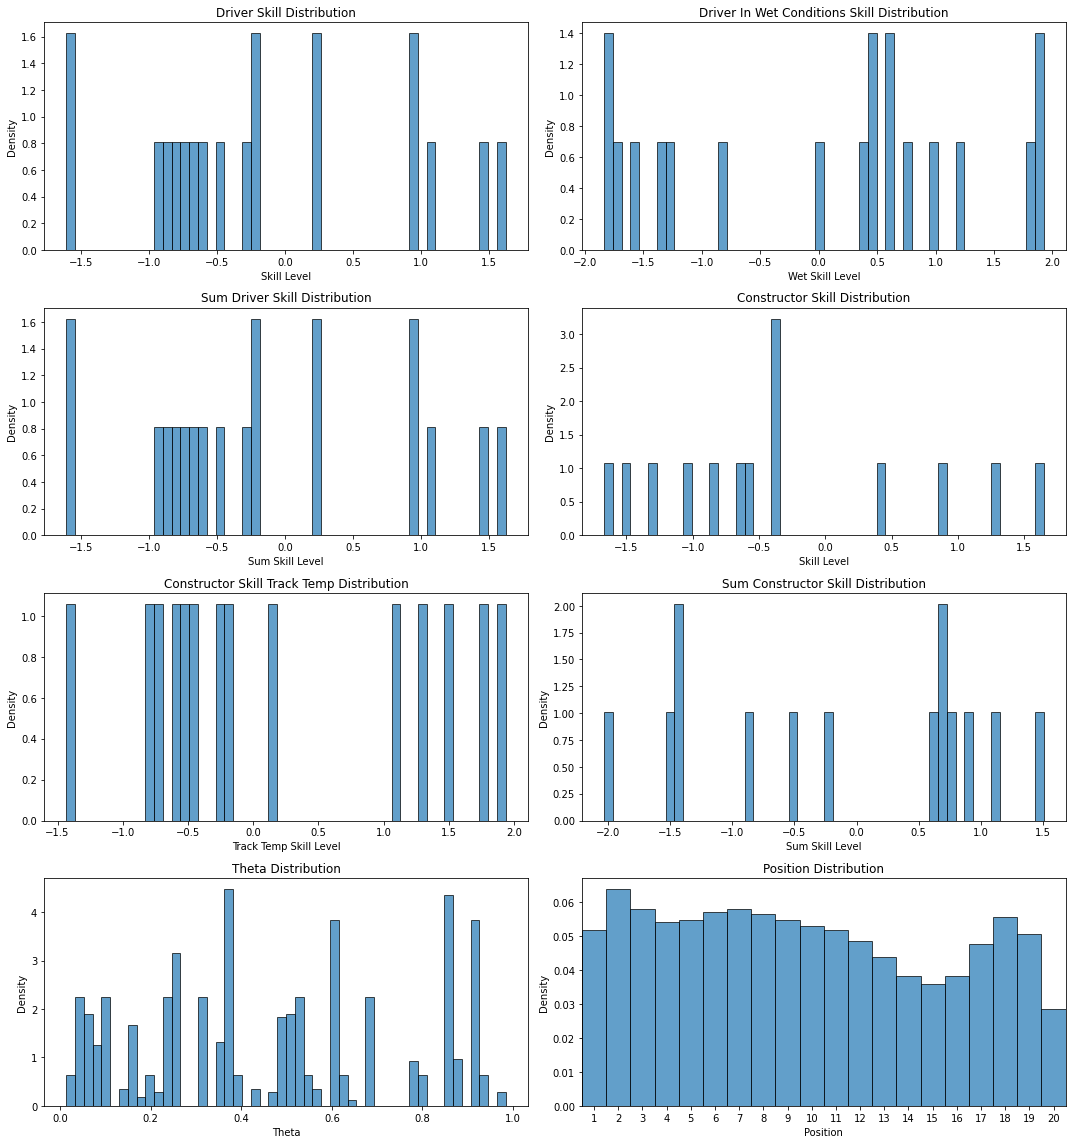

In [87]:
driver_skill_flat = posterior_model_2.stan_variable('driver_skill').flatten()
driver_skill_wet_flat = posterior_model_2.stan_variable('driver_skill_wet').flatten()
driver_skill_sum_flat = posterior_model_2.stan_variable('driver_skill_sum').flatten()
constructor_skill_flat = posterior_model_2.stan_variable('constructor_skill').flatten()
constructor_skill_flat_track_temp = posterior_model_2.stan_variable('constructor_skill_track_temp').flatten()
constructor_skill_flat_sum = posterior_model_2.stan_variable('constructor_skill_sum').flatten()
position_flat = posterior_model_2.stan_variable('position_predicted').flatten() + 1
theta_flat = posterior_model_2.stan_variable('theta').flatten()


fig, axs = plt.subplots(4, 2, figsize=(15, 16))

axs[0, 0].hist(driver_skill_flat, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[0, 0].set_title('Driver Skill Distribution')
axs[0, 0].set_xlabel('Skill Level')
axs[0, 0].set_ylabel('Density')

axs[0, 1].hist(driver_skill_wet_flat, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[0, 1].set_title('Driver In Wet Conditions Skill Distribution')
axs[0, 1].set_xlabel('Wet Skill Level')
axs[0, 1].set_ylabel('Density')

axs[1, 0].hist(driver_skill_sum_flat, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[1, 0].set_title('Sum Driver Skill Distribution')
axs[1, 0].set_xlabel('Sum Skill Level')
axs[1, 0].set_ylabel('Density')

axs[1, 1].hist(constructor_skill_flat, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[1, 1].set_title('Constructor Skill Distribution')
axs[1, 1].set_xlabel('Skill Level')
axs[1, 1].set_ylabel('Density')

axs[2, 0].hist(constructor_skill_flat_track_temp, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[2, 0].set_title('Constructor Skill Track Temp Distribution')
axs[2, 0].set_xlabel('Track Temp Skill Level')
axs[2, 0].set_ylabel('Density')

axs[2, 1].hist(constructor_skill_flat_sum, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[2, 1].set_title('Sum Constructor Skill Distribution')
axs[2, 1].set_xlabel('Sum Skill Level')
axs[2, 1].set_ylabel('Density')

axs[3, 0].hist(theta_flat, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[3, 0].set_title('Theta Distribution')
axs[3, 0].set_xlabel('Theta')
axs[3, 0].set_ylabel('Density')

axs[3, 1].hist(position_flat, bins=np.arange(1, 22) - 0.5, edgecolor='black', alpha=0.7, density=True)
axs[3, 1].set_title('Position Distribution')
axs[3, 1].set_xlabel('Position')
axs[3, 1].set_ylabel('Density')
axs[3, 1].set_xticks(range(1, 21))
axs[3, 1].set_xlim([0.5, 20.5])

# Adjust layout
plt.tight_layout()
plt.show()

Incorporating basic model parameters associated with track temperature and rainfall has expanded the range of $\theta$ values and significantly altered the position distribution. Analysis indicates that this adjustment has positively impacted the model's performance.

### 6.4. Results for individual drivers and constructors

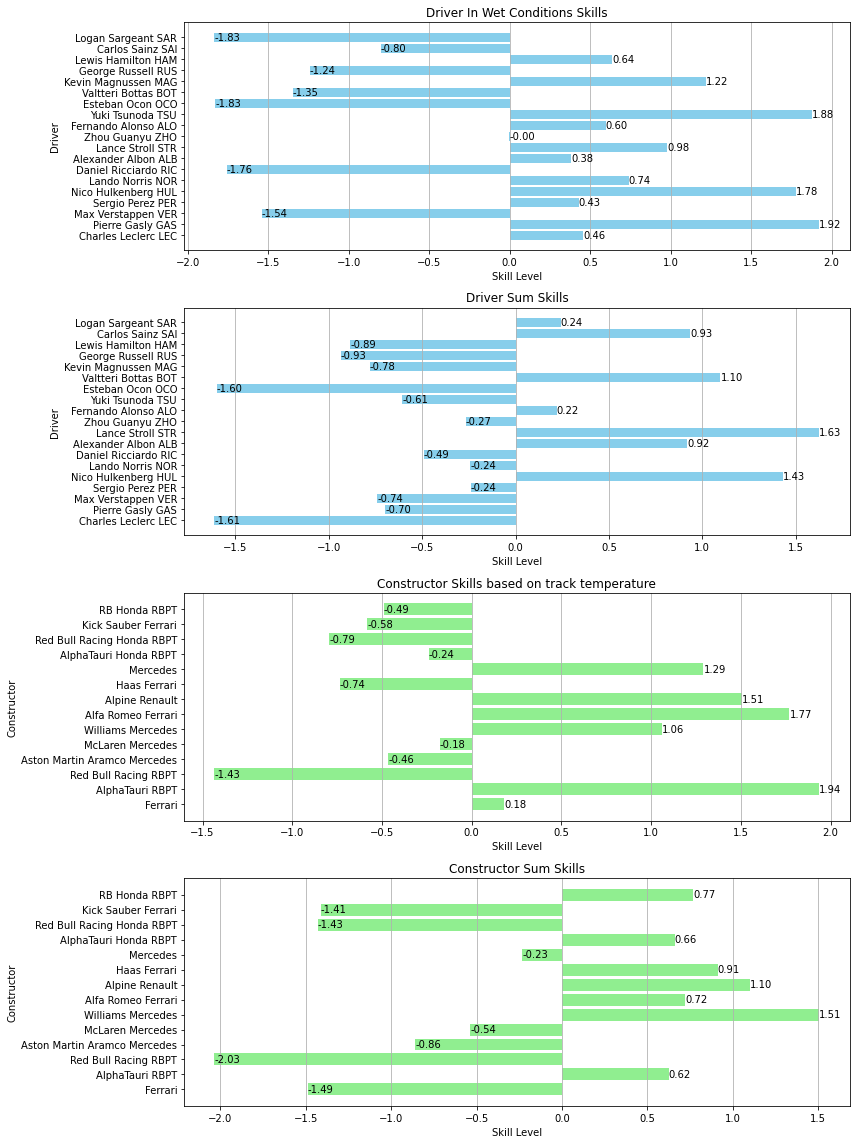

In [89]:
driver_skill_sum_wet_model2 = posterior_model_2.stan_variable('driver_skill_wet')
driver_skill_model2_sum = posterior_model_2.stan_variable('driver_skill_sum')
constructor_skill_model2_track_temp = posterior_model_2.stan_variable('constructor_skill_sum_track_temp')
constructor_skill_model2_sum = posterior_model_2.stan_variable('constructor_skill_sum')

unique_driver_names = df['Driver'].unique()
unique_constructor_names = df['Car'].unique()

mean_driver_skill_wet_model2 = np.mean(driver_skill_sum_wet_model2, axis=0)
mean_driver_skill_model2_sum = np.mean(driver_skill_model2_sum, axis=0)
mean_constructor_skill_model2_track_temp = np.mean(constructor_skill_model2_track_temp, axis=0)
mean_constructor_skill_model2_sum = np.mean(constructor_skill_model2_sum, axis=0)


fig, axs = plt.subplots(4, 1, figsize=(12, 16))

bars = axs[0].barh(unique_driver_names, mean_driver_skill_wet_model2, color='skyblue')
axs[0].set_xlabel('Skill Level')
axs[0].set_ylabel('Driver')
axs[0].set_title('Driver In Wet Conditions Skills')
axs[0].grid(axis='x')
for bar in bars:
    axs[0].text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', 
                va='center', ha='left', color='black')
    

bars = axs[1].barh(unique_driver_names, mean_driver_skill_model2_sum, color='skyblue')
axs[1].set_xlabel('Skill Level')
axs[1].set_ylabel('Driver')
axs[1].set_title('Driver Sum Skills')
axs[1].grid(axis='x')
for bar in bars:
    axs[1].text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', 
                va='center', ha='left', color='black')


bars = axs[2].barh(unique_constructor_names, mean_constructor_skill_model2_track_temp, color='lightgreen')
axs[2].set_xlabel('Skill Level')
axs[2].set_ylabel('Constructor')
axs[2].set_title('Constructor Skills based on track temperature')
axs[2].grid(axis='x')
for bar in bars:
    axs[2].text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', 
                va='center', ha='left', color='black')


bars = axs[3].barh(unique_constructor_names, mean_constructor_skill_model2_sum, color='lightgreen')
axs[3].set_xlabel('Skill Level')
axs[3].set_ylabel('Constructor')
axs[3].set_title('Constructor Sum Skills')
axs[3].grid(axis='x')
for bar in bars:
    axs[3].text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', 
                va='center', ha='left', color='black')

plt.tight_layout()
plt.show()

## 7. Posterior analysis (model 3)

### 7.1.  Issues with the sampling
There were no issues. All samplings were conducted without any obstacles.

### 7.2. Analysis of samples from the posterior predictive distribution

In [91]:
df = pd.read_csv('data_processing/processed_data.csv')
unique_drivers = df['Driver'].nunique()
unique_constructors = df['Car'].nunique()
drivers_indices = pd.factorize(df['Driver'])[0] + 1
constructors_indices = pd.factorize(df['Car'])[0] + 1
df['Pos (race)'] = df['Pos (race)'] - 1
positions = df['Pos (race)'].values
rainy = df['TotalRainfall'].astype(bool).values.astype(int)
avg_track_temp = df['AvgTrackTemp'].values
qualifying_positions = df['Pos (qualifying)'].values
data = {
    'N': len(df),
    'D': unique_drivers,
    'C': unique_constructors,
    'drivers': drivers_indices,
    'constructors': constructors_indices,
    'position': positions,
    'rainy': rainy,
    'qualifying_position': qualifying_positions
}
model = CmdStanModel(stan_file='stan/model3_posterior.stan')
posterior_model_3 = model.sample(data=data, iter_warmup=1, iter_sampling=1000, chains=1, seed=20052024)

INFO:cmdstanpy:compiling stan file /home/stan/model3_posterior.stan to exe file /home/stan/model3_posterior
INFO:cmdstanpy:compiled model executable: /home/stan/model3_posterior
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:06 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


IndexError: index 6 is out of bounds for axis 0 with size 6

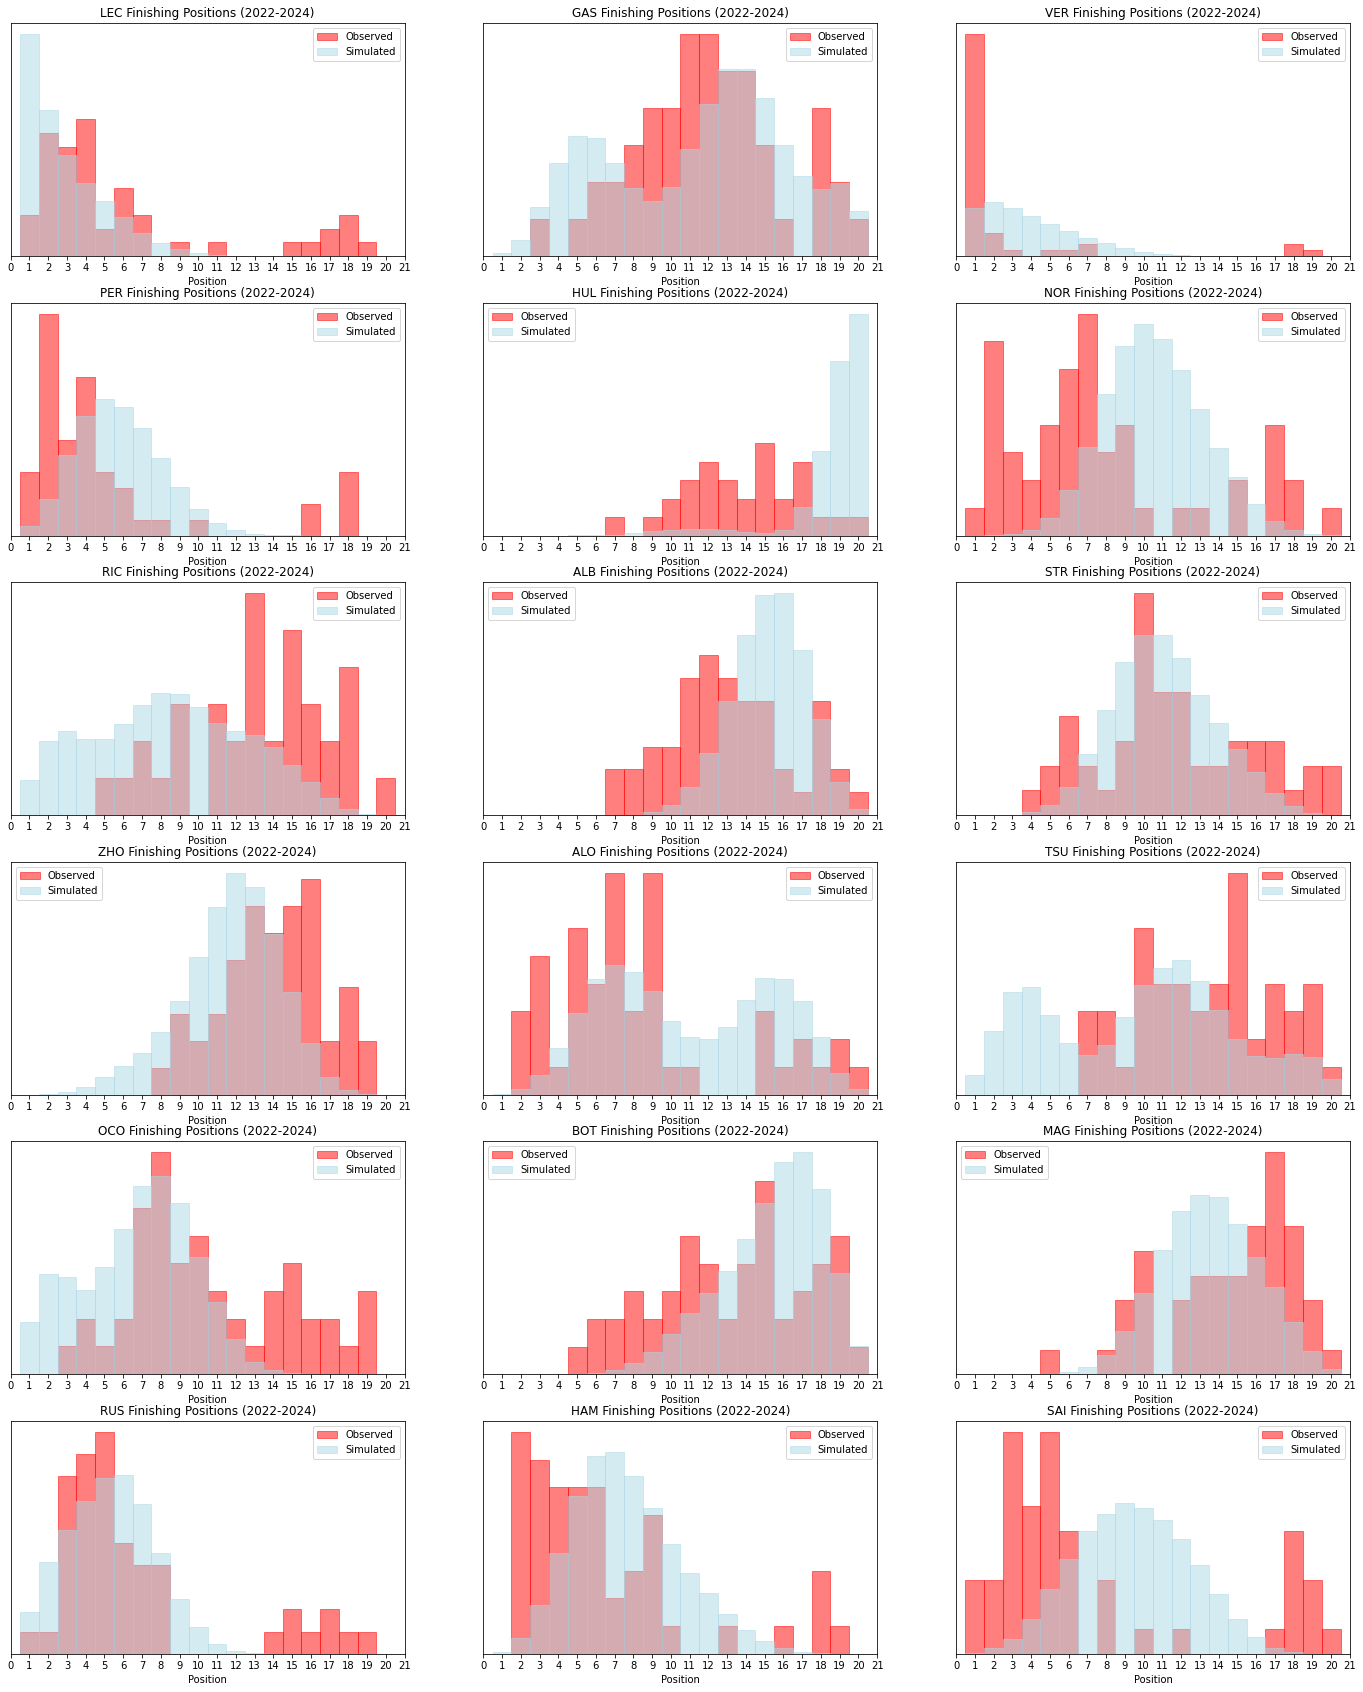

In [92]:
positions_predicted_model3 = posterior_model_3.stan_variable('position_predicted')
plot_comparision_between_simulated_and_observed_for_drivers(positions_predicted_model3, df)

The posterior predictive distributions from Model 3 show improved alignment with the observed race results compared to Model 1 and 2, capturing both central tendencies and variability more accurately.\
This model, which incorporates qualifying positions, accounts for key factors affecting race outcomes, resulting in better simulation of peak positions and spread. However, while Model 3 generally reduces bias, there are still occasional discrepancies in capturing extreme values and the precise shapes of some distributions.\
Overall, Model 3 offers a more comprehensive fit, reflecting the importance of qualifying performance in determining race results.

### 7.3. Analysis of parameter marginal disrtibutions

In [ ]:
driver_skill_flat = posterior_model_3.stan_variable('driver_skill').flatten()
driver_skill_wet_flat = posterior_model_3.stan_variable('driver_skill_wet').flatten()
driver_skill_qualifying = posterior_model_3.stan_variable('driver_skill_qualifying').flatten()
driver_skill_sum_flat = posterior_model_3.stan_variable('driver_skill_sum').flatten()
constructor_skill_flat = posterior_model_3.stan_variable('constructor_skill').flatten()
position_flat = posterior_model_3.stan_variable('position_predicted').flatten() + 1
theta_flat = posterior_model_3.stan_variable('theta').flatten()

fig, axs = plt.subplots(4, 2, figsize=(18, 12))

axs[0, 0].hist(driver_skill_flat, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[0, 0].set_title('Driver Skill Distribution')
axs[0, 0].set_xlabel('Skill Level')
axs[0, 0].set_ylabel('Density')

axs[0, 1].hist(driver_skill_wet_flat, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[0, 1].set_title('Driver In Wet Conditions Skill Distribution')
axs[0, 1].set_xlabel('Wet Skill Level')
axs[0, 1].set_ylabel('Density')

axs[1, 0].hist(driver_skill_qualifying, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[1, 0].set_title('Driver Qualifying Skill Distribution')
axs[1, 0].set_xlabel('Qualifying Skill Level')
axs[1, 0].set_ylabel('Density')

axs[1, 1].hist(driver_skill_sum_flat, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[1, 1].set_title('Sum Driver Skill Distribution')
axs[1, 1].set_xlabel('Sum Skill Level')
axs[1, 1].set_ylabel('Density')

axs[2, 0].hist(constructor_skill_flat, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[2, 0].set_title('Constructor Skill Distribution')
axs[2, 0].set_xlabel('Skill Level')
axs[2, 0].set_ylabel('Density')

axs[2, 1].hist(theta_flat, bins=50, edgecolor='black', alpha=0.7, density=True)
axs[2, 1].set_title('Theta Distribution')
axs[2, 1].set_xlabel('Theta')
axs[2, 1].set_ylabel('Density')

axs[3, 0].hist(position_flat, bins=np.arange(1, 22) - 0.5, edgecolor='black', alpha=0.7, density=True)
axs[3, 0].set_title('Position Distribution')
axs[3, 0].set_xlabel('Position')
axs[3, 0].set_ylabel('Density')
axs[3, 0].set_xticks(range(1, 21))
axs[3, 0].set_xlim([0.5, 20.5])

fig.delaxes(axs[3, 1])
plt.tight_layout()
plt.show()

### 7.4. Results for individual drivers and constructors

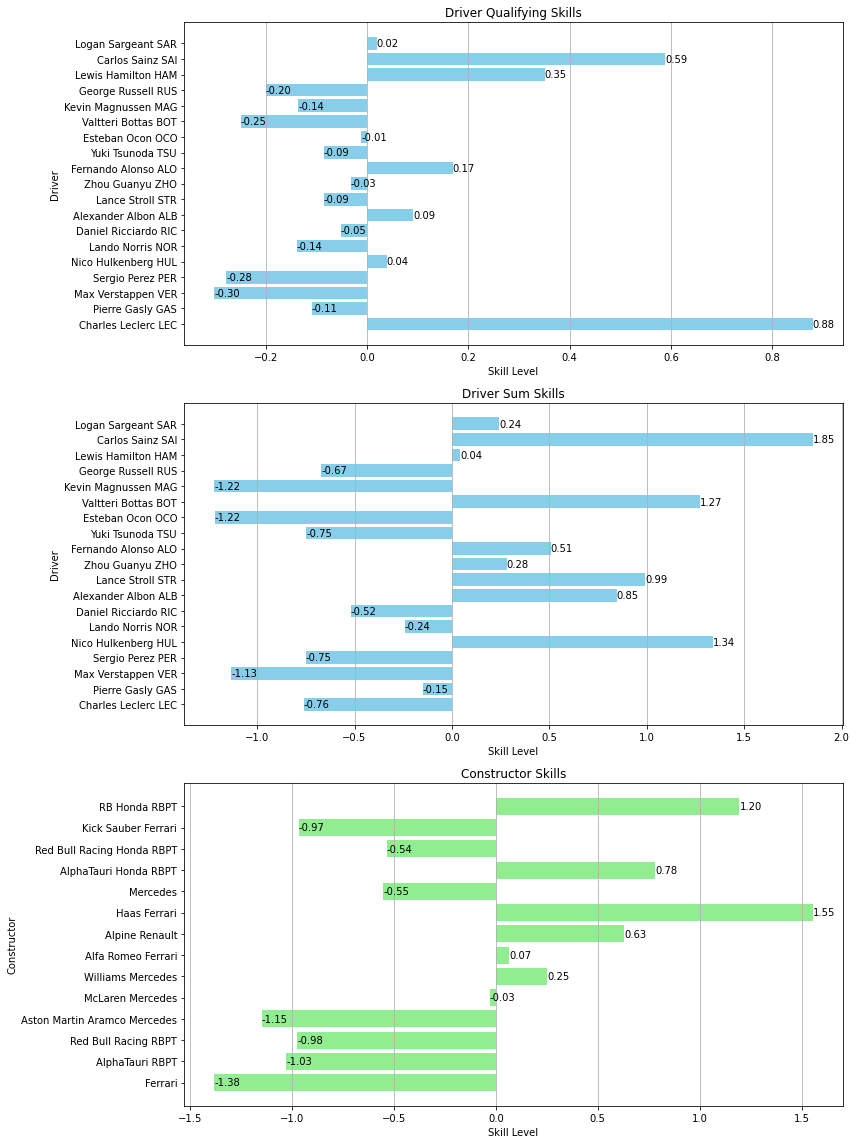

In [95]:
driver_skill_model3 = posterior_model_3.stan_variable('driver_skill_sum')
driver_skill_model3_qualifying = posterior_model_3.stan_variable('driver_skill_qualifying')
constructor_skill_model3 = posterior_model_3.stan_variable('constructor_skill')
unique_driver_names = df['Driver'].unique()
unique_constructor_names = df['Car'].unique()
mean_driver_skill_model3 = np.mean(driver_skill_model3, axis=0)
mean_driver_skill_model3_qualifying = np.mean(driver_skill_model3_qualifying, axis=0)
mean_constructor_skill_model3 = np.mean(constructor_skill_model3, axis=0)

fig, axs = plt.subplots(3, 1, figsize=(12, 16))

bars = axs[0].barh(unique_driver_names, mean_driver_skill_model3_qualifying, color='skyblue')
axs[0].set_xlabel('Skill Level')
axs[0].set_ylabel('Driver')
axs[0].set_title('Driver Qualifying Skills')
axs[0].grid(axis='x')
for bar in bars:
    axs[0].text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', 
                va='center', ha='left', color='black')


bars = axs[1].barh(unique_driver_names, mean_driver_skill_model3, color='skyblue')
axs[1].set_xlabel('Skill Level')
axs[1].set_ylabel('Driver')
axs[1].set_title('Driver Sum Skills')
axs[1].grid(axis='x')
for bar in bars:
    axs[1].text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', 
                va='center', ha='left', color='black')
    
bars = axs[2].barh(unique_constructor_names, mean_constructor_skill_model3, color='lightgreen')
axs[2].set_xlabel('Skill Level')
axs[2].set_ylabel('Constructor')
axs[2].set_title('Constructor Skills')
axs[2].grid(axis='x')
for bar in bars:
    axs[2].text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', 
                va='center', ha='left', color='black')

plt.tight_layout()
plt.show()

## 8. Model comaprison

### 8.1. General comparison

In [100]:
def plot_position_comparison(first_model_to_compare, second_model_to_compare, df):
    n_rows, n_cols = 6, 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 5*n_rows))

    n_bins = np.arange(22) - 0.5
    drivers_names = df['Driver'].unique().tolist()

    for driver_index, driver_name in enumerate(drivers_names):
        specified_driver = df['Driver'].eq(driver_name)
        results = df[specified_driver]

        row_idx = driver_index // n_cols
        col_idx = driver_index % n_cols

        axes[row_idx, col_idx].hist((results['Pos (race)']).tolist(), bins=n_bins, rwidth=1, color='red', edgecolor='red', density=True, label='Observed', alpha=0.5)

        results_idx = results.index
        simulated_positions_model1 = first_model_to_compare.T[results_idx].flatten() + 1
        simulated_positions_model2 = second_model_to_compare.T[results_idx].flatten() + 1
        
        if np.array_equal(first_model_to_compare, positions_predicted_model1):
            model1_label = 'Simulated Model 1'
        elif np.array_equal(first_model_to_compare, positions_predicted_model2):
            model1_label = 'Simulated Model 2'
        elif np.array_equal(first_model_to_compare, positions_predicted_model3):
            model1_label = 'Simulated Model 3'
        
        if np.array_equal(second_model_to_compare, positions_predicted_model1):
            model2_label = 'Simulated Model 1'
        elif np.array_equal(second_model_to_compare, positions_predicted_model2):
            model2_label = 'Simulated Model 2'
        elif np.array_equal(second_model_to_compare, positions_predicted_model3):
            model2_label = 'Simulated Model 3'

        axes[row_idx, col_idx].hist(simulated_positions_model1, bins=n_bins, rwidth=1, color='lightblue', edgecolor='lightblue', density=True, label=model1_label, alpha=0.5)
        axes[row_idx, col_idx].hist(simulated_positions_model2, bins=n_bins, rwidth=1, color='orange', edgecolor='orange', density=True, label=model2_label, alpha=0.5)
        axes[row_idx, col_idx].set_xticks(range(22))
        axes[row_idx, col_idx].set_xlim([0, 21])
        axes[row_idx, col_idx].set_yticks([])
        axes[row_idx, col_idx].set_title(driver_name.split()[-1] + ' Finishing Positions (2022-2024)')
        axes[row_idx, col_idx].legend()
        axes[row_idx, col_idx].set_xlabel('Position')

    fig.tight_layout()
    plt.show()

IndexError: index 6 is out of bounds for axis 0 with size 6

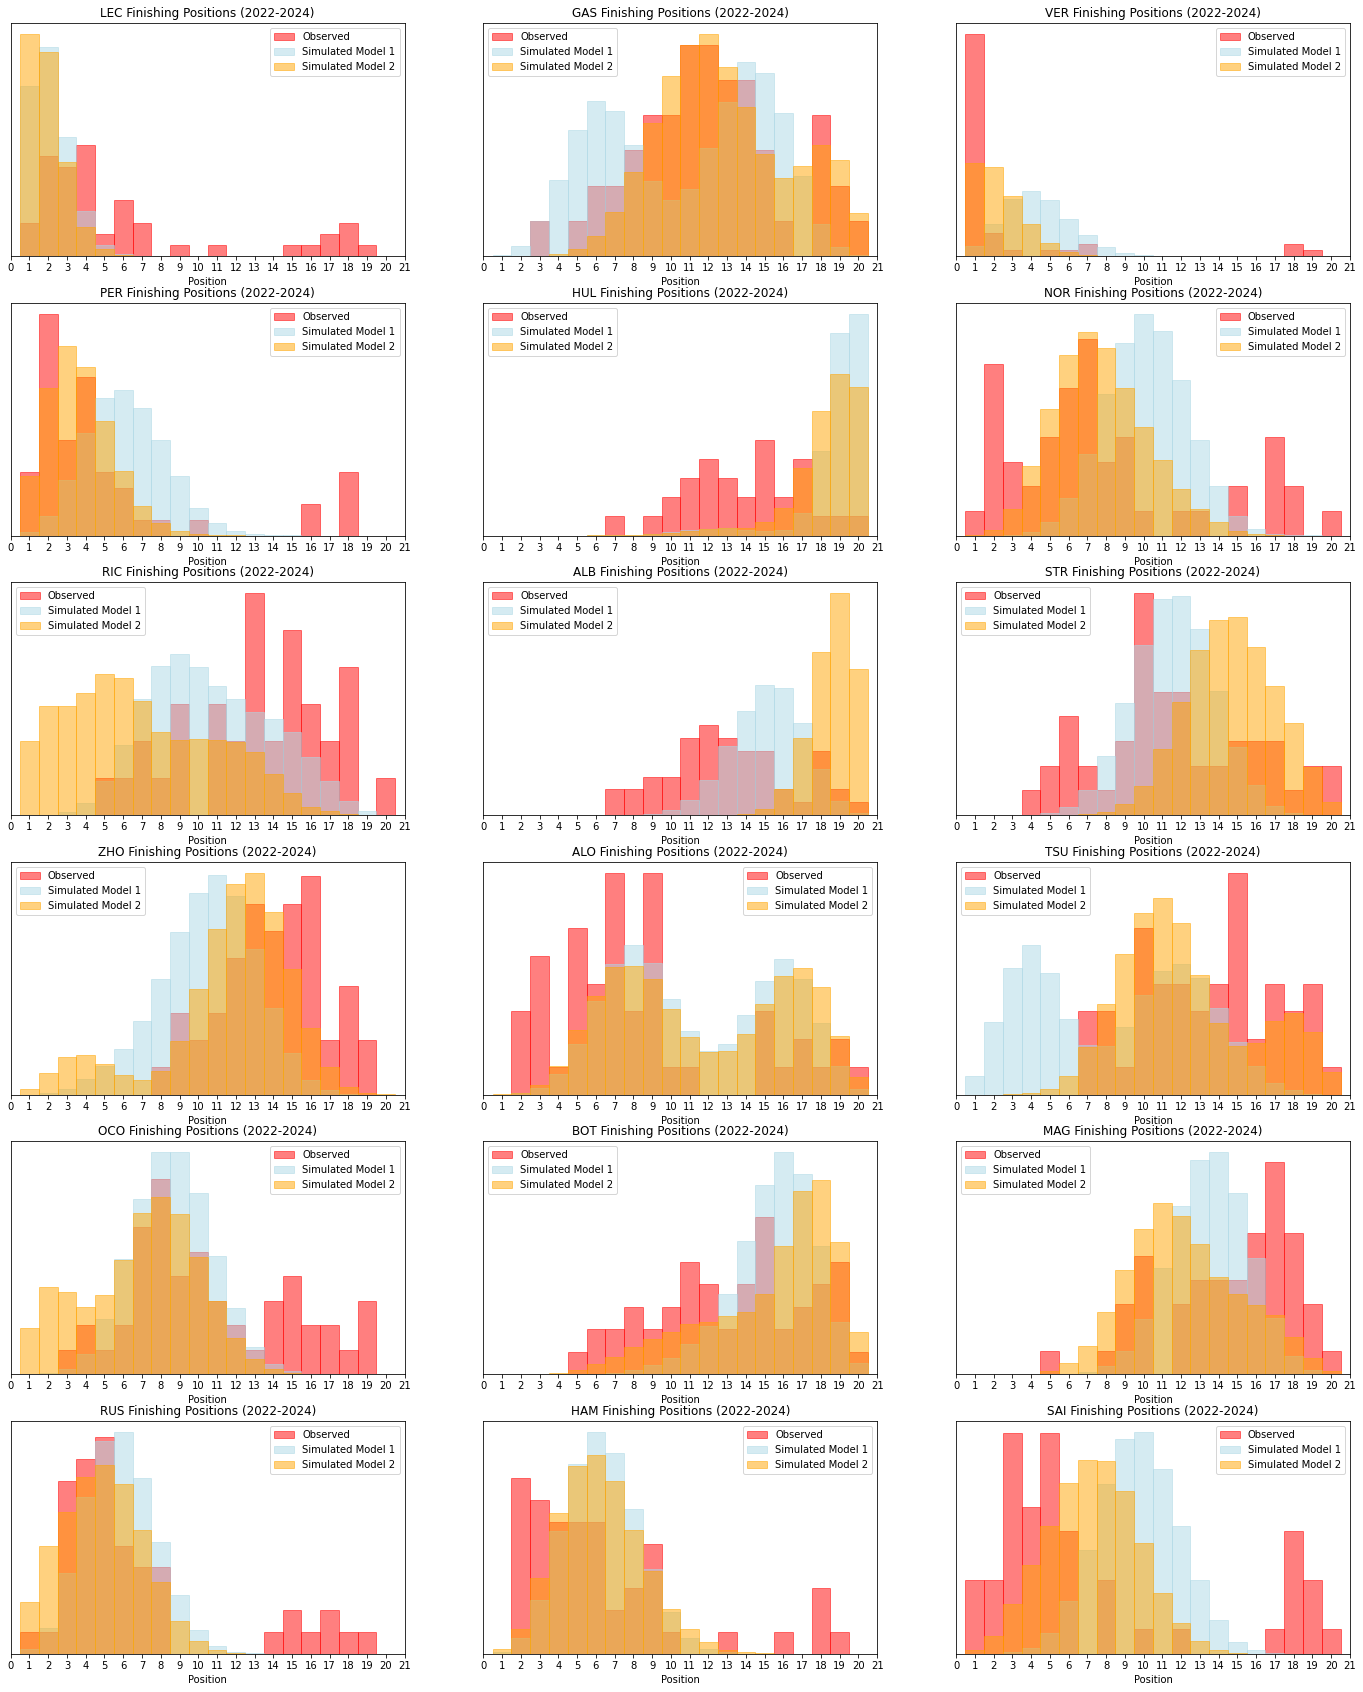

In [101]:
df = pd.read_csv('data_processing/processed_data.csv')
plot_position_comparison(positions_predicted_model1, positions_predicted_model2, df)

IndexError: index 6 is out of bounds for axis 0 with size 6

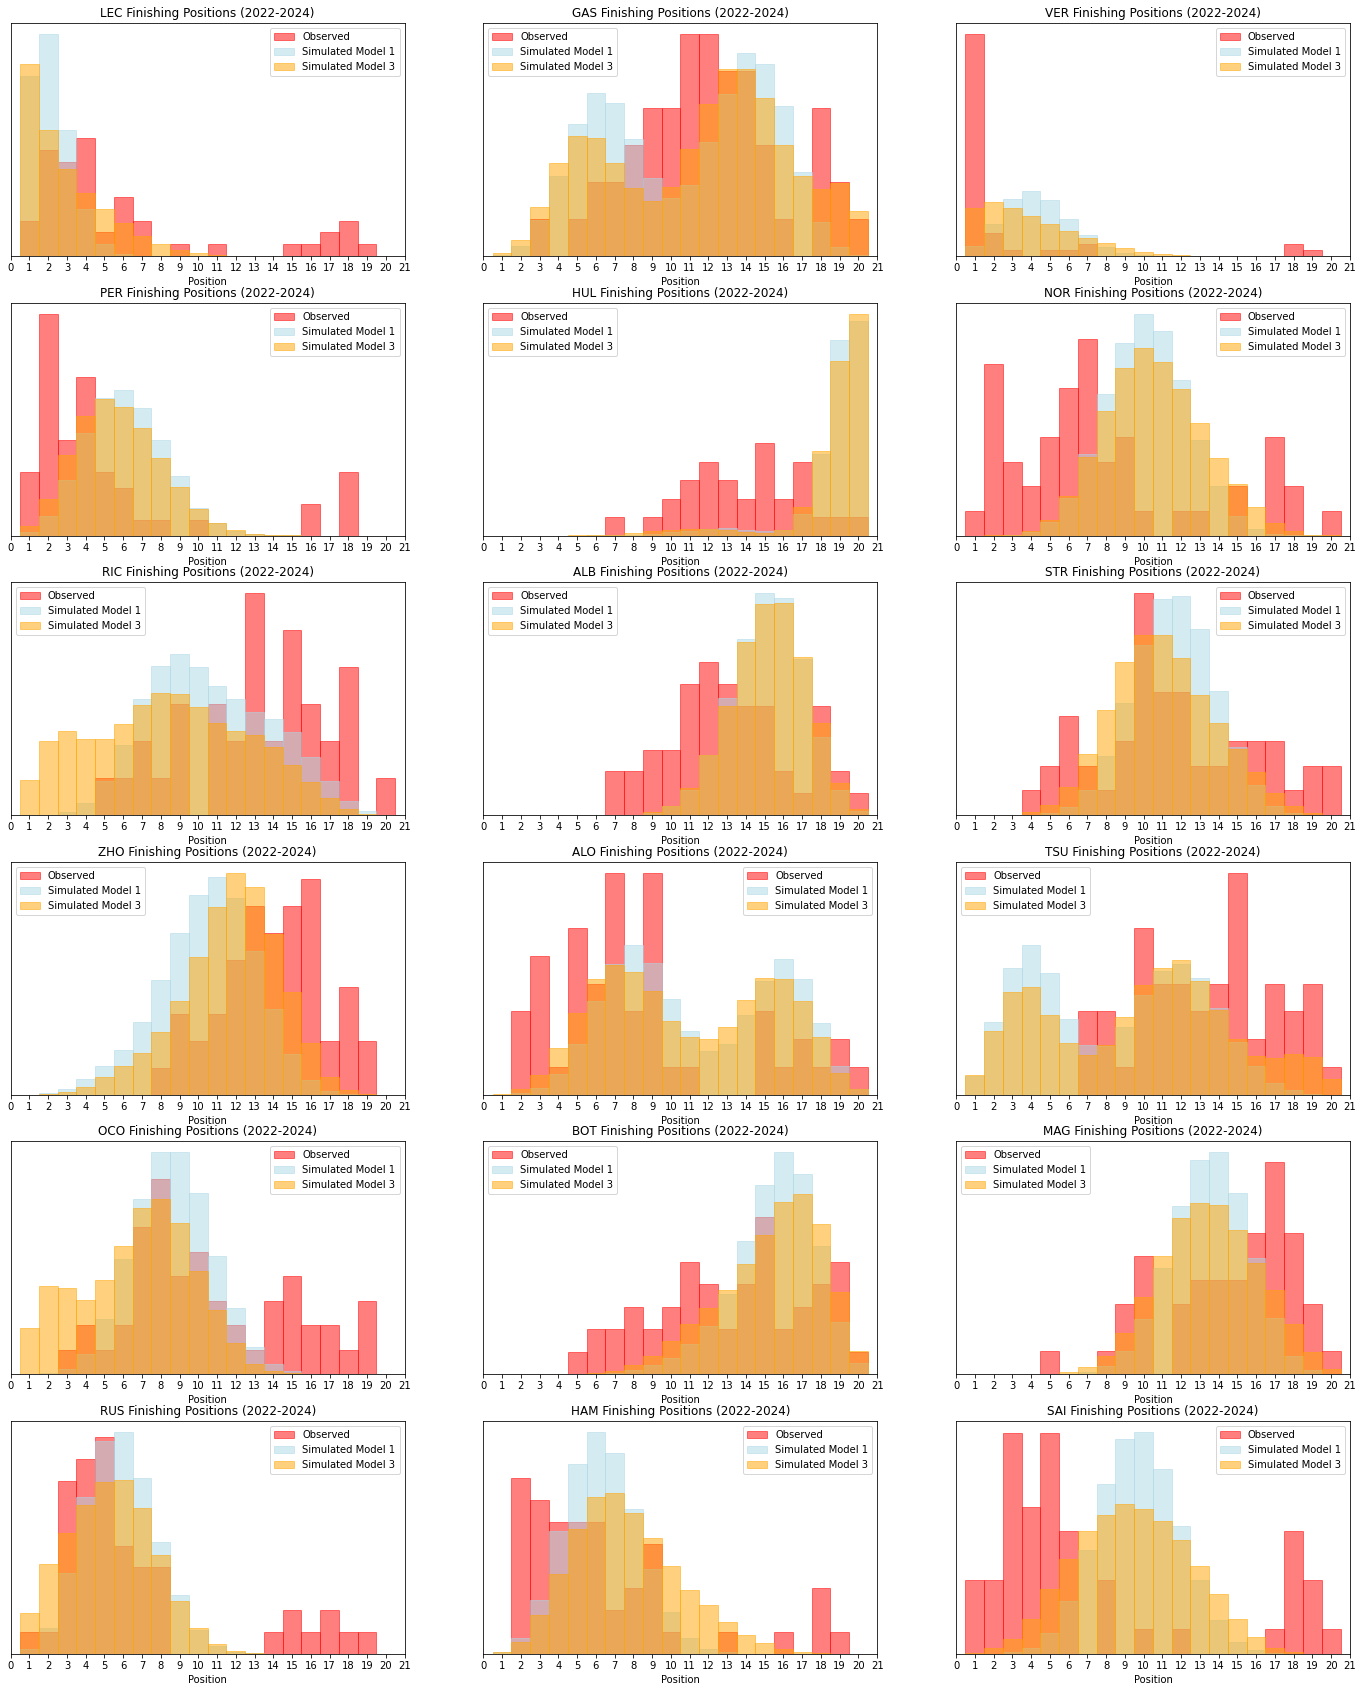

In [102]:
plot_position_comparison(positions_predicted_model1, positions_predicted_model3, df)

IndexError: index 6 is out of bounds for axis 0 with size 6

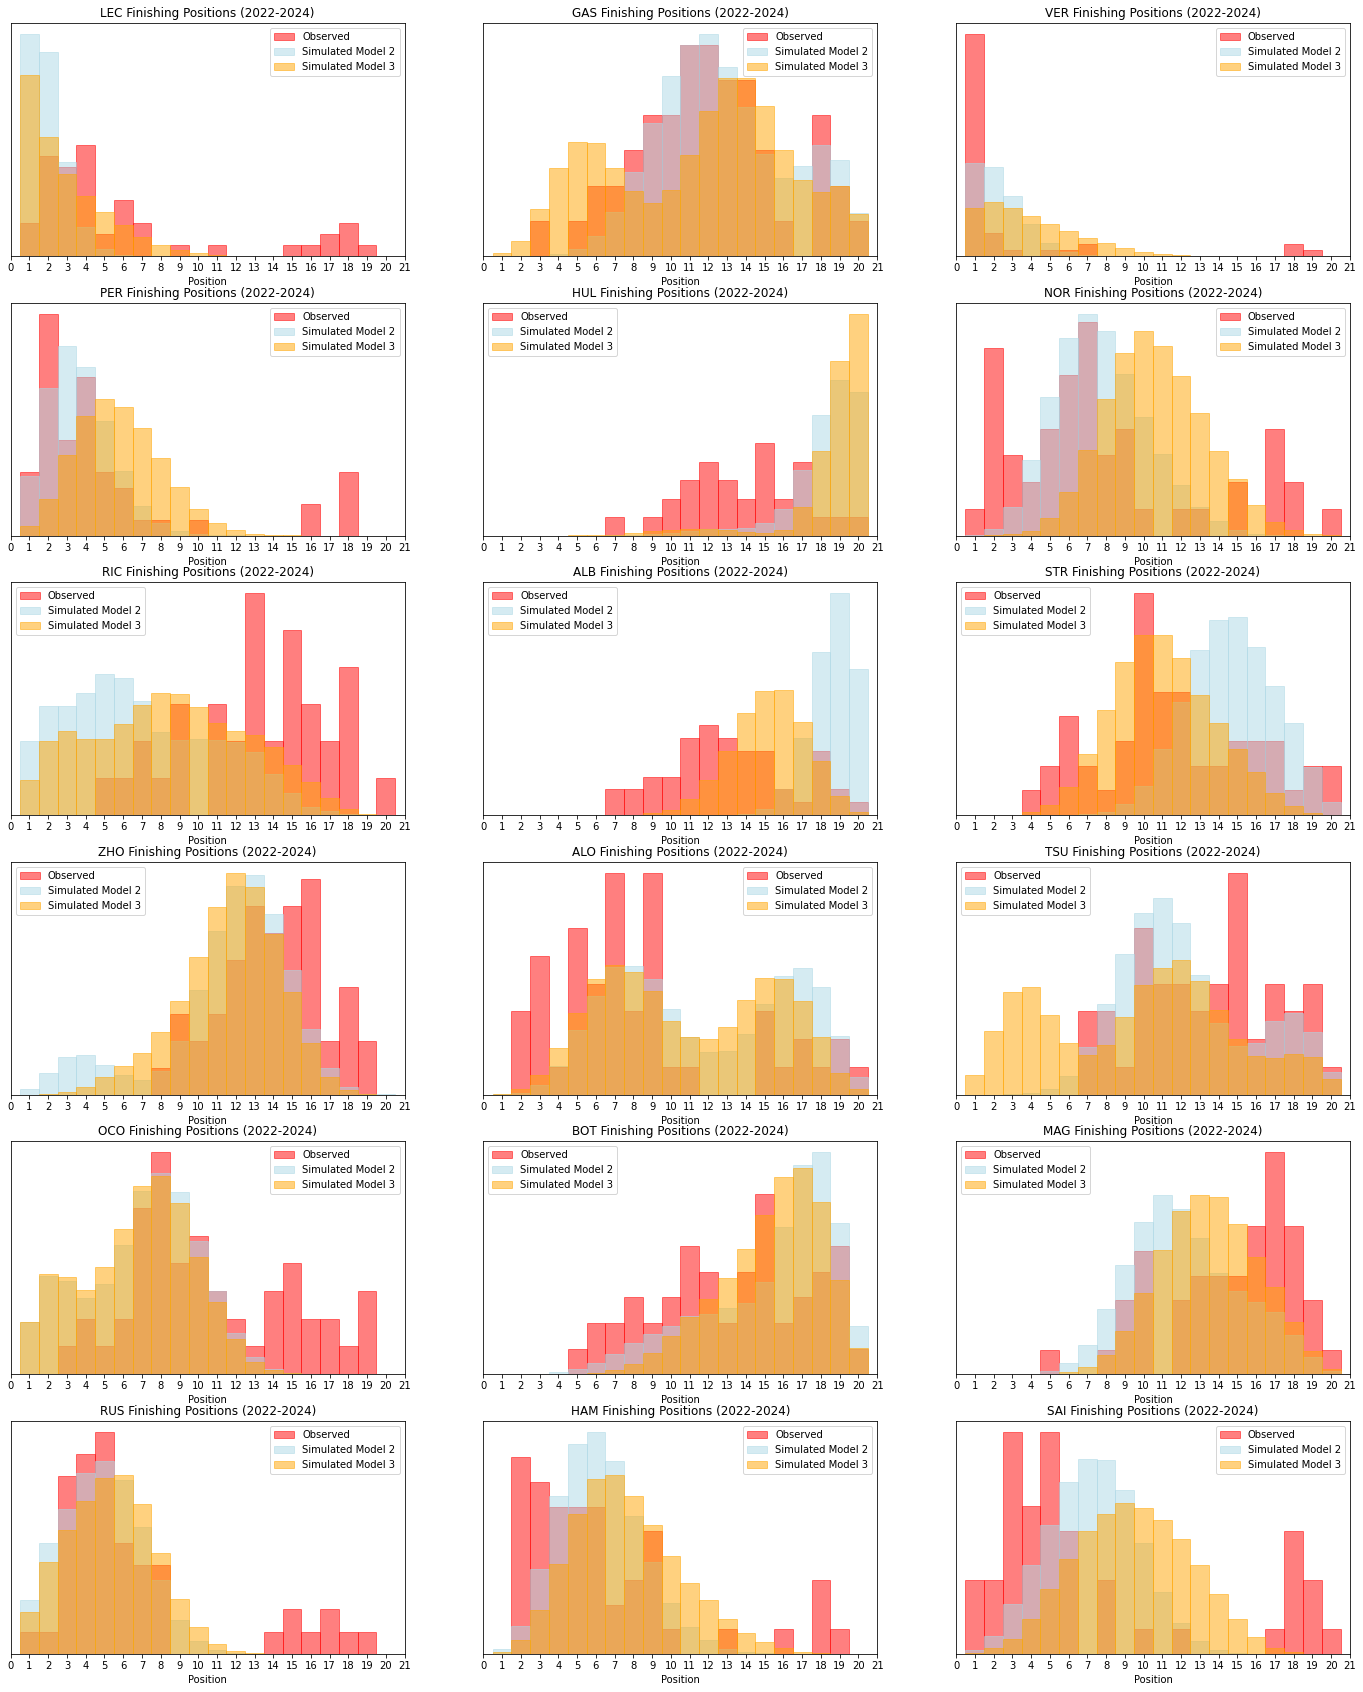

In [103]:
plot_position_comparison(positions_predicted_model2, positions_predicted_model3, df)

### 8.2. Comparison of individual drivers and constructors

#### 8.2.1 Drivers

IndexError: index 6 is out of bounds for axis 0 with size 6

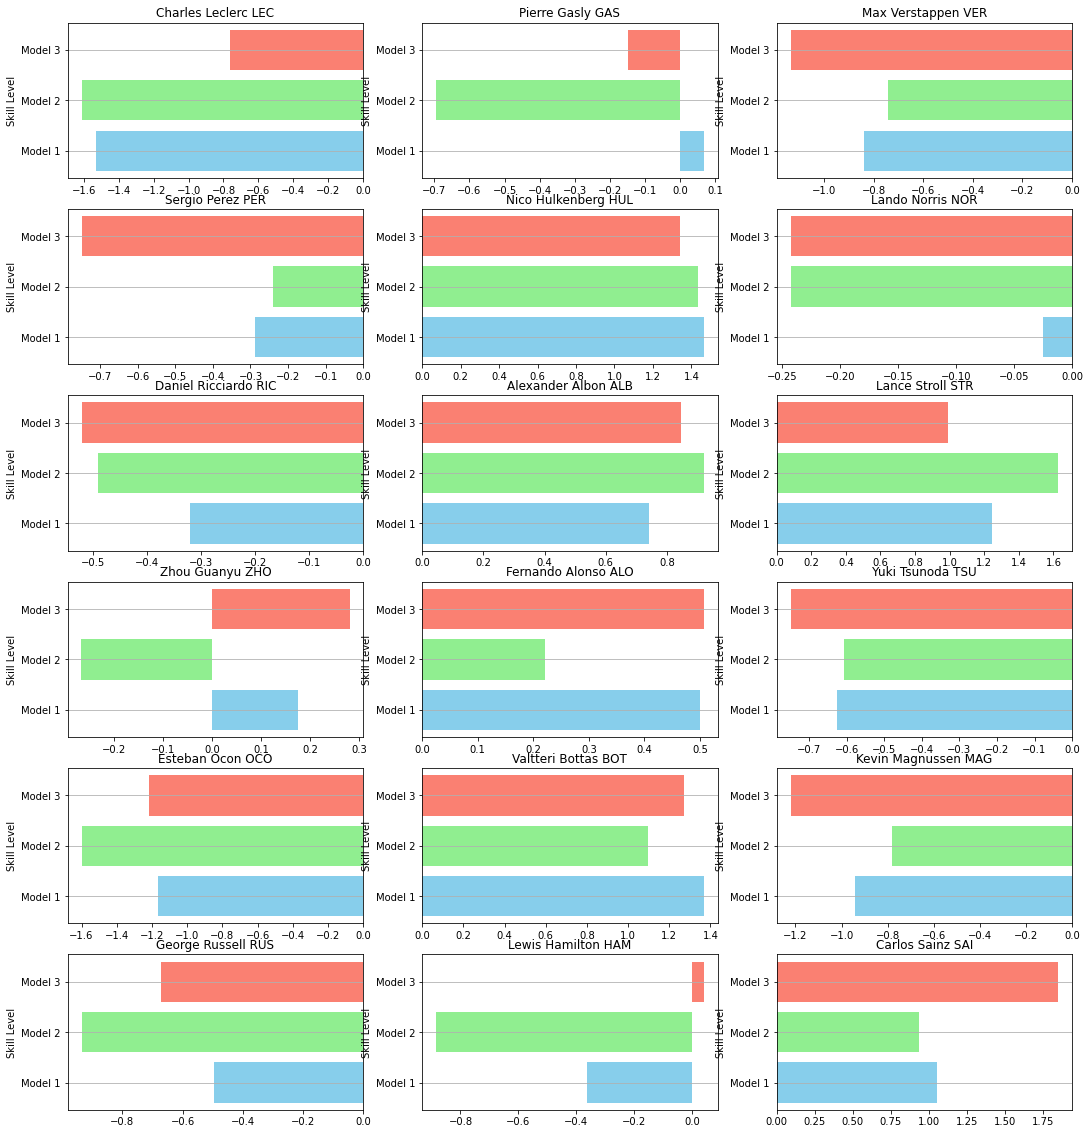

In [104]:
unique_driver_names = df['Driver'].unique()
models = ['Model 1', 'Model 2', 'Model 3']

fig, axs = plt.subplots(6, 3, figsize=(18, 20))
for i, driver in enumerate(unique_driver_names):
    value_model1 = mean_driver_skill_model1[i]
    value_model2 = mean_driver_skill_model2_sum[i]
    value_model3 = mean_driver_skill_model3[i]

    axs[i // 3, i % 3].barh(models, [value_model1, value_model2, value_model3], 
                           color=['skyblue', 'lightgreen', 'salmon'])
    axs[i // 3, i % 3].set_ylabel('Skill Level')
    axs[i // 3, i % 3].set_title(f'{driver}')
    axs[i // 3, i % 3].grid(axis='y')

plt.tight_layout()
plt.show()

#### 8.2.2 Constructors

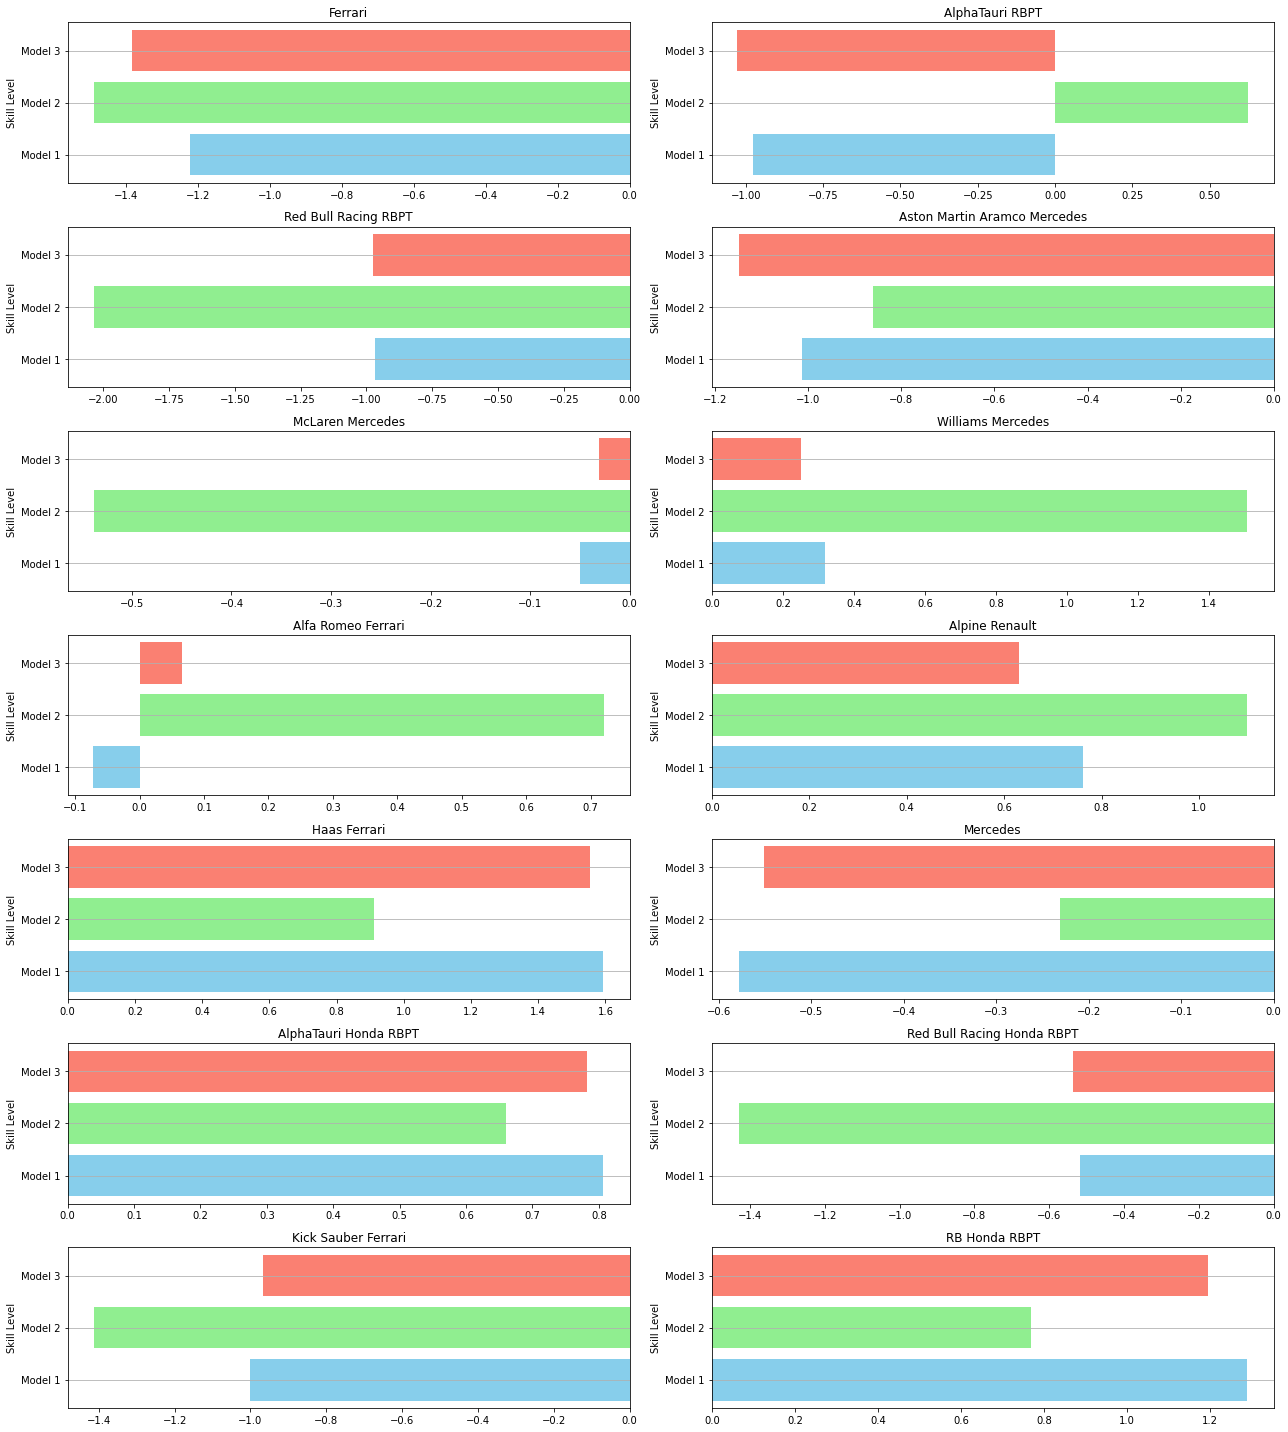

In [105]:
unique_constructor_names = df['Car'].unique()
models = ['Model 1', 'Model 2', 'Model 3']

fig, axs = plt.subplots(7, 2, figsize=(18, 20))
for i, constructor in enumerate(unique_constructor_names):
    value_model1 = mean_constructor_skill_model1[i]
    value_model2 = mean_constructor_skill_model2_sum[i]
    value_model3 = mean_constructor_skill_model3[i]

    axs[i // 2, i % 2].barh(models, [value_model1, value_model2, value_model3], 
                           color=['skyblue', 'lightgreen', 'salmon'])
    axs[i // 2, i % 2].set_ylabel('Skill Level')
    axs[i // 2, i % 2].set_title(f'{constructor}')
    axs[i // 2, i % 2].grid(axis='y')

plt.tight_layout()
plt.show()

### 8.3. WAIC and PSIS-LOO results

#### 8.3.1 WAIC

In [ ]:
comp_dict = {'Model 1': posterior_model_1, 'Model 2': posterior_model_2, 'Model 3': posterior_model_3}
comp_waic = az.compare(comp_dict, ic='waic', scale='deviance')
az.plot_compare(comp_waic)
plt.title("Waic metric")
plt.show()

In [ ]:
comp_waic

#### 8.3.2 PSIS-LOO 

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated sh

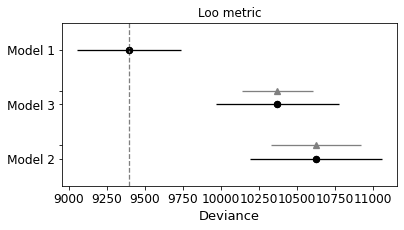

In [106]:
comp_dict = {'Model 1': posterior_model_1, 'Model 2': posterior_model_2, 'Model 3': posterior_model_3}
comp_loo = az.compare(comp_dict, ic='loo', scale='deviance')
az.plot_compare(comp_loo)
plt.title("Loo metric")
plt.show()

In [107]:
comp_loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Model 1,0,9395.807400,0.0,0.000000,0.409751,339.084542,0.000000,True,deviance
Model 3,1,10369.369924,0.0,973.562524,0.171640,403.020614,234.249550,True,deviance
Model 2,2,10623.716254,0.0,1227.908854,0.418609,432.117407,295.061652,True,deviance


## 9. Summary

## 10. References

1. Stan Development Team. (n.d.). Stan documentation. Retrieved June 15, 2024, from [https://mc-stan.org/users/documentation/](https://mc-stan.org/users/documentation/)

2. The Jupyter Development Team. (n.d.). Jupyter notebook documentation. Retrieved June 15, 2024, from [https://docs.jupyter.org/en/latest/](https://docs.jupyter.org/en/latest/)

3. van Kesteren, E.-J., & Bergkamp, T. (2023). Bayesian analysis of Formula One race results: disentangling driver skill and constructor advantage.

4. Python Software Foundation. (n.d.). Python documentation. Retrieved June 15, 2024, from [https://docs.python.org/3.11](https://docs.python.org/3.11)

5. Formula 1. (n.d.). Official Formula 1 website. Retrieved June 15, 2024, from [https://www.formula1.com/](https://www.formula1.com/)
